In [1]:
# imports
import pandas as pd
import IPython.display as display
import matplotlib.pyplot as plt
import numpy as np
import time
from google.colab import files
import os
import tensorflow as tf
import os
import zipfile
from tensorflow.keras import layers
from tensorflow.keras import Model
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from tensorflow.keras.optimizers import RMSprop
import random
from tensorflow.keras.preprocessing.image import img_to_array, load_img
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import array_to_img, img_to_array, load_img

In [2]:
uploades = files.upload()

Saving SkinCancer.zip to SkinCancer.zip


In [3]:
local_zip = 'SkinCancer.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall()
zip_ref.close()

# Setup

In [4]:
base_dir = 'SkinCancer'
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')

# Directory with our training cat pictures
train_malignant_dir = os.path.join(train_dir, 'malignant')

# Directory with our training dog pictures
train_benign_dir = os.path.join(train_dir, 'benign')

# Directory with our validation cat pictures
validation_malignant_dir = os.path.join(validation_dir, 'malignant')

# Directory with our validation dog pictures
validation_benign_dir = os.path.join(validation_dir, 'benign')

In [5]:
train_malignant_fnames = os.listdir(train_malignant_dir)
train_malignant_fnames.sort()
print(train_malignant_fnames[:10])

train_benign_fnames = os.listdir(train_benign_dir)
train_benign_fnames.sort()
print(train_benign_fnames[:10])

['10.jpg', '100.jpg', '1000.jpg', '1001.jpg', '1002.jpg', '1004.jpg', '1006.jpg', '1008.jpg', '101.jpg', '1010.jpg']
['100.jpg', '1000.jpg', '1001.jpg', '1002.jpg', '1004.jpg', '1005.jpg', '1007.jpg', '1008.jpg', '1009.jpg', '101.jpg']


In [6]:
# 25% validation data, 75% training data
print('total training malignant images:', len(os.listdir(train_malignant_dir)))
print('total training benign images:', len(os.listdir(train_benign_dir)))
print('total validation malignant images:', len(os.listdir(validation_malignant_dir)))
print('total validation benign images:', len(os.listdir(validation_benign_dir)))

total training malignant images: 1197
total training benign images: 1440
total validation malignant images: 300
total validation benign images: 360


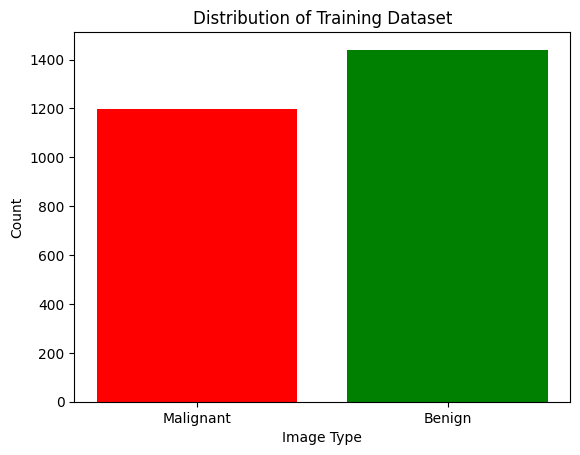

In [ ]:
# visualizing training dataset

train_malignant_data = len(os.listdir(train_malignant_dir))
train_benign_data = len(os.listdir(train_benign_dir))
labels = ['Malignant', 'Benign']

values = [train_malignant_data, train_benign_data]

color = ['red', 'green']
plt.bar(labels, values, color = color)

plt.title('Distribution of Training Dataset')
plt.xlabel('Image Type')
plt.ylabel('Count')

plt.show()

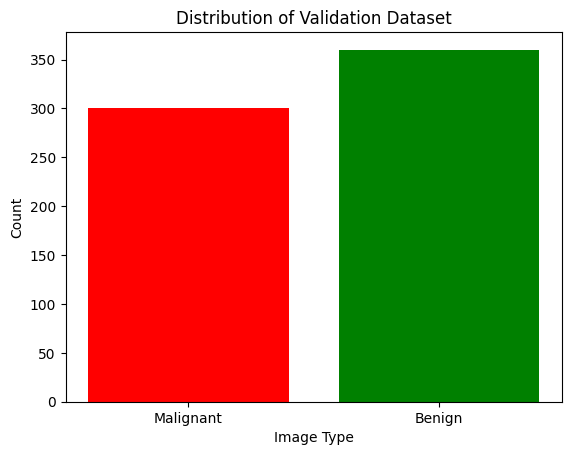

In [ ]:
# visualizing validation dataset

validation_malignant_data = len(os.listdir(validation_malignant_dir))
validation_benign_data = len(os.listdir(validation_benign_dir))
labels = ['Malignant', 'Benign']

values = [validation_malignant_data, validation_benign_data]

color = ['red', 'green']
plt.bar(labels, values, color = color)

plt.title('Distribution of Validation Dataset')
plt.xlabel('Image Type')
plt.ylabel('Count')

plt.show()

In [ ]:
%matplotlib inline

# Parameters for our graph; we'll output images in a 4x4 configuration
nrows = 4
ncols = 4

# Index for iterating over images
pic_index = 0

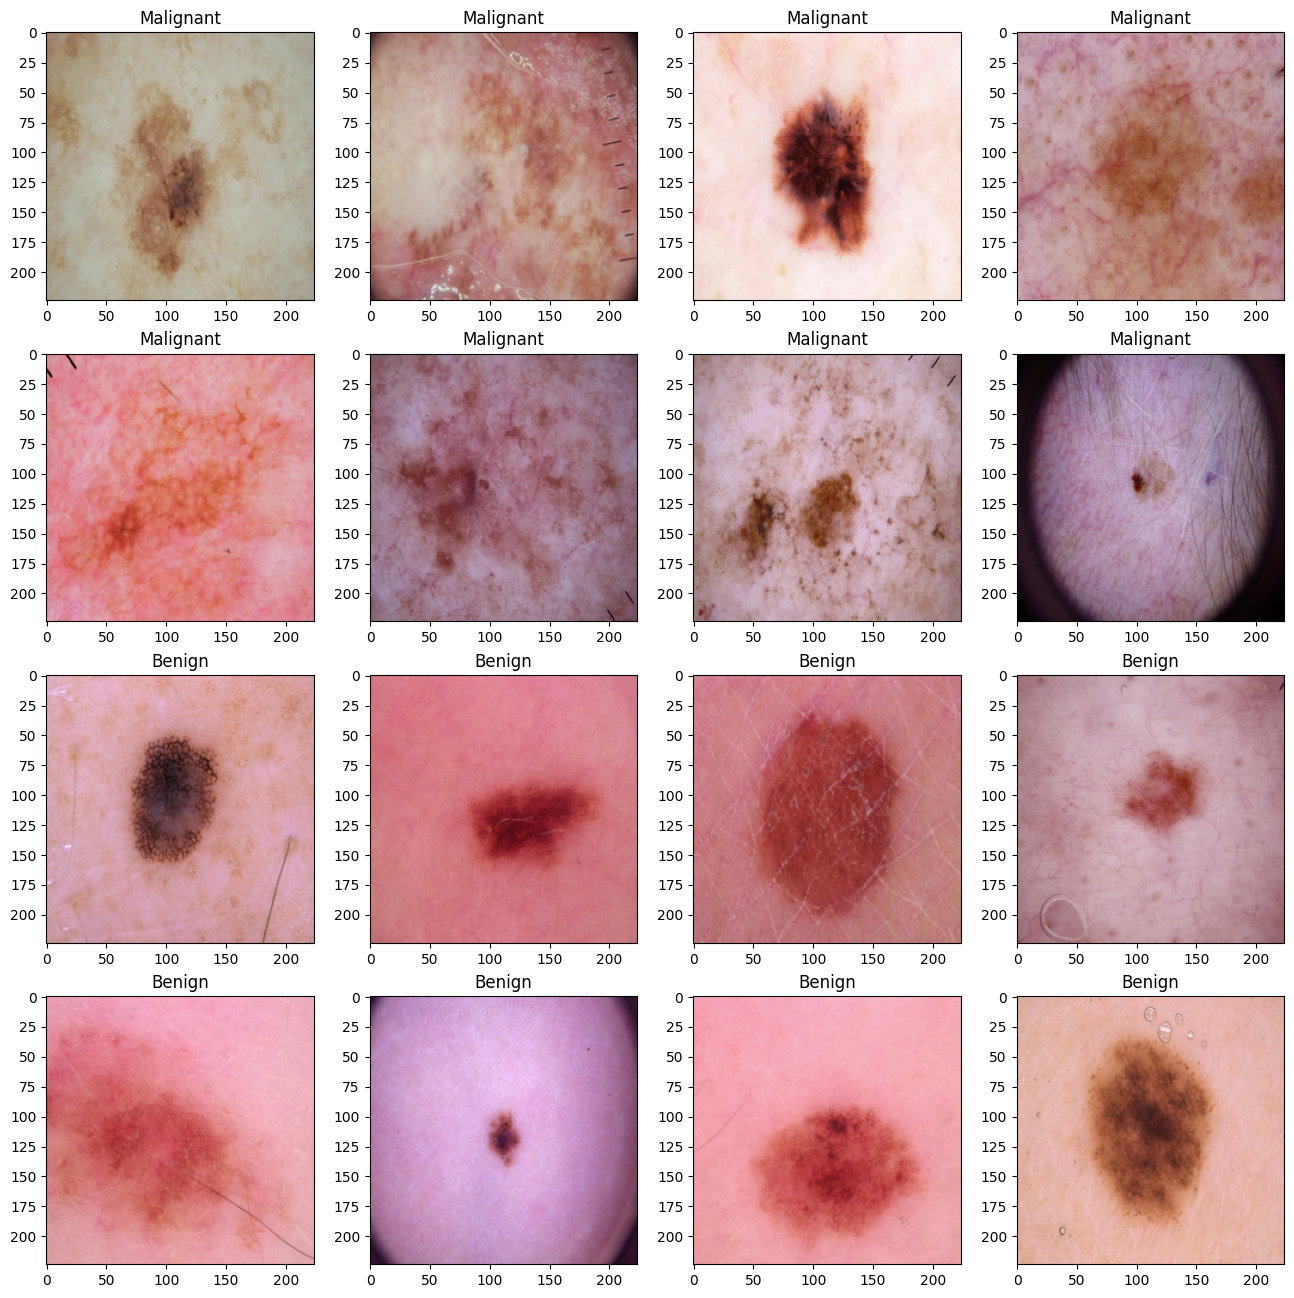

In [ ]:
# Set up matplotlib fig, and size it to fit 4x4 pics
fig = plt.gcf()
fig.set_size_inches(ncols * 4, nrows * 4)

pic_index += 8
next_malignant_pix = [os.path.join(train_malignant_dir, fname) 
                for fname in train_malignant_fnames[pic_index-8:pic_index]]
next_benign_pix = [os.path.join(train_benign_dir, fname) 
                for fname in train_benign_fnames[pic_index-8:pic_index]]

for i, img_path in enumerate(next_malignant_pix+next_benign_pix):
  # Set up subplot; subplot indices start at 1
  sp = plt.subplot(nrows, ncols, i + 1)
  sp.axis('On') # show axes (or gridlines)

  img = mpimg.imread(img_path)
  plt.imshow(img)

  # Set title for the subplot
  if i < len(next_malignant_pix):
    sp.set_title("Malignant")
  else:
    sp.set_title("Benign")

plt.show()

plt.show()

# Building a Small Convnet from Scratch

The images that will go into our convnet are 150x150 color images (in the next section on Data Preprocessing, we'll add handling to resize all the images to 150x150 before feeding them into the neural network).

Let's code up the architecture. We will stack 3 {convolution + relu + maxpooling} modules. Our convolutions operate on 3x3 windows and our maxpooling layers operate on 2x2 windows. Our first convolution extracts 16 filters, the following one extracts 32 filters, and the last one extracts 64 filters.

In [ ]:
# Our input feature map is 150x150x3: 150x150 for the image pixels, and 3 for the three color channels: R, G, and B
img_input = layers.Input(shape=(150, 150, 3))

# First convolution extracts 16 filters that are 3x3
# Convolution is followed by max-pooling layer with a 2x2 window
x = layers.Conv2D(16, 3, activation='relu')(img_input)
x = layers.MaxPooling2D(2)(x)

# Second convolution extracts 32 filters that are 3x3
# Convolution is followed by max-pooling layer with a 2x2 window
x = layers.Conv2D(32, 3, activation='relu')(x)
x = layers.MaxPooling2D(2)(x)

# Third convolution extracts 64 filters that are 3x3
# Convolution is followed by max-pooling layer with a 2x2 window
x = layers.Conv2D(64, 3, activation='relu')(x)
x = layers.MaxPooling2D(2)(x)

On top of it we stick two fully-connected layers. Because we are facing a two-class classification problem, i.e. a binary classification problem, we will end our network with a sigmoid activation, so that the output of our network will be a single scalar between 0 and 1, encoding the probability that the current image is class 1 (as opposed to class 0). In our problem, we are trying to predict if the image is Malignant or Benign. 

In [ ]:
# Flatten feature map to a 1-dim tensor so we can add fully connected layers
x = layers.Flatten()(x)

# Create a fully connected layer with ReLU activation and 512 hidden units
x = layers.Dense(512, activation='relu')(x)

# Create output layer with a single node and sigmoid activation
output = layers.Dense(1, activation='sigmoid')(x)

# Create model:
# input = input feature map
# output = input feature map + stacked convolution/maxpooling layers + fully 
# connected layer + sigmoid output layer
model = Model(img_input, output)

Summary of the model architecture:

In [ ]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 148, 148, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 74, 74, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 72, 72, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 36, 36, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 34, 34, 64)        18496 

The "output shape" column shows how the size of your feature map evolves in each successive layer. The convolution layers reduce the size of the feature maps by a bit due to padding, and each pooling layer halves the feature map.

Next, we'll configure the specifications for model training. We will train our model with the binary_crossentropy loss, because it's a binary classification problem and our final activation is a sigmoid. We will use the rmsprop optimizer with a learning rate of 0.001. During training, we will want to monitor classification accuracy.

NOTE: In this case, using the RMSprop optimization algorithm is preferable to stochastic gradient descent (SGD), because RMSprop automates learning-rate tuning for us. (Other optimizers, such as Adam and Adagrad, also automatically adapt the learning rate during training, and would work equally well here.)

In [ ]:
model.compile(loss='binary_crossentropy', optimizer=RMSprop(learning_rate=0.001), metrics=['acc'])

# Data Preprocessing
Let's set up data generators that will read pictures in our source folders, convert them to float32 tensors, and feed them (with their labels) to our network. We'll have one generator for the training images and one for the validation images. Our generators will yield batches of 20 images of size 150x150 and their labels (binary).

As you may already know, data that goes into neural networks should usually be normalized in some way to make it more amenable to processing by the network. (It is uncommon to feed raw pixels into a convnet.) In our case, we will preprocess our images by normalizing the pixel values to be in the [0, 1] range (originally all values are in the [0, 255] range).

In Keras this can be done via the keras.preprocessing.image.ImageDataGenerator class using the rescale parameter. This ImageDataGenerator class allows you to instantiate generators of augmented image batches (and their labels) via .flow(data, labels) or .flow_from_directory(directory). These generators can then be used with the Keras model methods that accept data generators as inputs: fit_generator, evaluate_generator, and predict_generator.

In [ ]:
# All images will be rescaled by 1./255
train_datagen = ImageDataGenerator(rescale=1./255)
val_datagen = ImageDataGenerator(rescale=1./255)

# Flow training images in batches of 20 using train_datagen generator
train_generator = train_datagen.flow_from_directory(
        train_dir,  # This is the source directory for training images
        target_size=(150, 150),  # All images will be resized to 150x150
        batch_size=20,
        # Since we use binary_crossentropy loss, we need binary labels
        class_mode='binary')

# Flow validation images in batches of 20 using val_datagen generator
validation_generator = val_datagen.flow_from_directory(
        validation_dir,
        target_size=(150, 150),
        batch_size=20,
        class_mode='binary')

Found 2637 images belonging to 2 classes.
Found 660 images belonging to 2 classes.


Training on 2,637 images, validating on 660 images.

In [ ]:
history = model.fit(
      train_generator,
      steps_per_epoch=None, 
      epochs=15,
      validation_data=validation_generator,
      validation_steps=None, 
      verbose=2)

Epoch 1/15
132/132 - 87s - loss: 0.6212 - acc: 0.6712 - val_loss: 0.4716 - val_acc: 0.7697 - 87s/epoch - 661ms/step
Epoch 2/15
132/132 - 92s - loss: 0.4971 - acc: 0.7497 - val_loss: 0.5176 - val_acc: 0.6197 - 92s/epoch - 697ms/step
Epoch 3/15
132/132 - 79s - loss: 0.4623 - acc: 0.7656 - val_loss: 0.4225 - val_acc: 0.7803 - 79s/epoch - 601ms/step
Epoch 4/15
132/132 - 80s - loss: 0.4352 - acc: 0.7857 - val_loss: 0.3929 - val_acc: 0.8076 - 80s/epoch - 604ms/step
Epoch 5/15
132/132 - 79s - loss: 0.4067 - acc: 0.7911 - val_loss: 0.3738 - val_acc: 0.8167 - 79s/epoch - 599ms/step
Epoch 6/15
132/132 - 83s - loss: 0.3878 - acc: 0.8111 - val_loss: 0.4086 - val_acc: 0.8000 - 83s/epoch - 629ms/step
Epoch 7/15
132/132 - 81s - loss: 0.3662 - acc: 0.8187 - val_loss: 0.4035 - val_acc: 0.7697 - 81s/epoch - 610ms/step
Epoch 8/15
132/132 - 80s - loss: 0.3780 - acc: 0.8221 - val_loss: 0.4100 - val_acc: 0.7924 - 80s/epoch - 604ms/step
Epoch 9/15
132/132 - 83s - loss: 0.3466 - acc: 0.8312 - val_loss: 0.3802

1/1 [==============================] - 0s 158ms/step


<ipython-input-18-24c723c52160>:39: RuntimeWarning: invalid value encountered in true_divide
  x /= x.std()


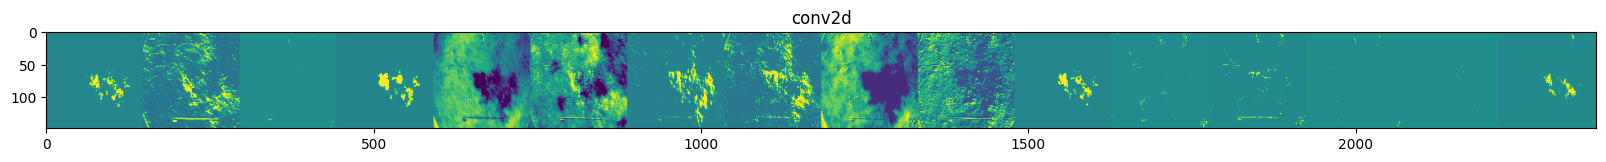

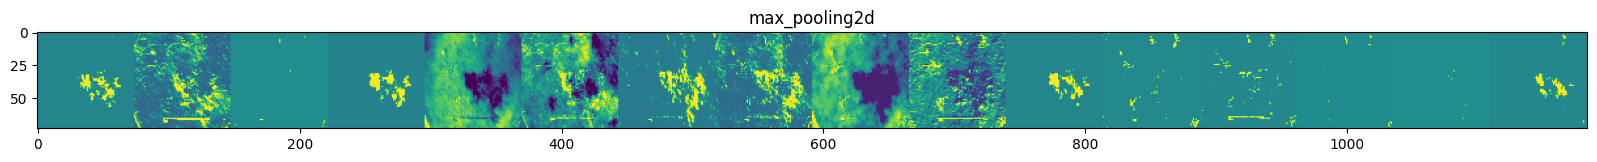

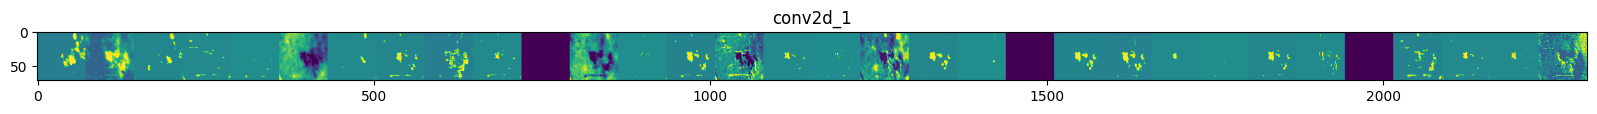

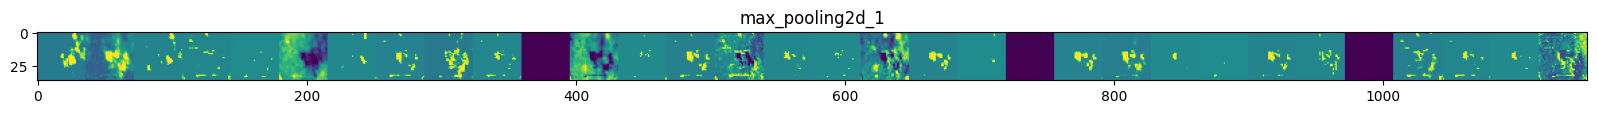

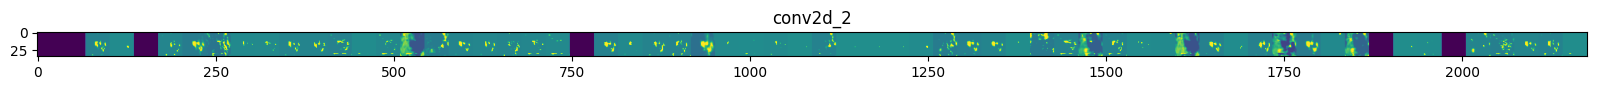

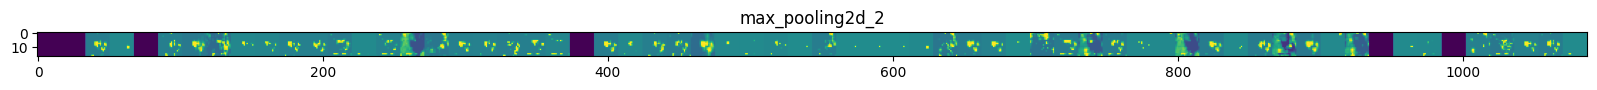

In [ ]:
# Let's define a new Model that will take an image as input, and will output
# intermediate representations for all layers in the previous model after
# the first.
successive_outputs = [layer.output for layer in model.layers[1:]]
visualization_model = Model(img_input, successive_outputs)

# Let's prepare a random input image of a malignant or benign tumor from the training set.
malignant_img_files = [os.path.join(train_malignant_dir, f) for f in train_malignant_fnames]
benign_img_files = [os.path.join(train_benign_dir, f) for f in train_benign_fnames]
img_path = random.choice(malignant_img_files + benign_img_files)

img = load_img(img_path, target_size=(150, 150))  # this is a PIL image
x = img_to_array(img)  # Numpy array with shape (150, 150, 3)
x = x.reshape((1,) + x.shape)  # Numpy array with shape (1, 150, 150, 3)

# Rescale by 1/255
x /= 255

# Let's run our image through our network, thus obtaining all
# intermediate representations for this image.
successive_feature_maps = visualization_model.predict(x)

# These are the names of the layers, so can have them as part of our plot
layer_names = [layer.name for layer in model.layers[1:]]

# Now let's display our representations
for layer_name, feature_map in zip(layer_names, successive_feature_maps):
  if len(feature_map.shape) == 4:
    # Just do this for the conv / maxpool layers, not the fully-connected layers
    n_features = feature_map.shape[-1]  # number of features in feature map
    # The feature map has shape (1, size, size, n_features)
    size = feature_map.shape[1]
    # We will tile our images in this matrix
    display_grid = np.zeros((size, size * n_features))
    for i in range(n_features):
      # Postprocess the feature to make it visually palatable
      x = feature_map[0, :, :, i]
      x -= x.mean()
      x /= x.std()
      x *= 64
      x += 128
      x = np.clip(x, 0, 255).astype('uint8')
      # We'll tile each filter into this big horizontal grid
      display_grid[:, i * size : (i + 1) * size] = x
    # Display the grid
    scale = 20. / n_features
    plt.figure(figsize=(scale * n_features, scale))
    plt.title(layer_name)
    plt.grid(False)
    plt.imshow(display_grid, aspect='auto', cmap='viridis')

<ipython-input-19-7206d8438e07>:6: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b" (-> color=(0.0, 0.0, 1.0, 1)). The keyword argument will take precedence.
  plt.plot(epochs, accuracy_values, "b", label="Training Accuracy", color = 'red')


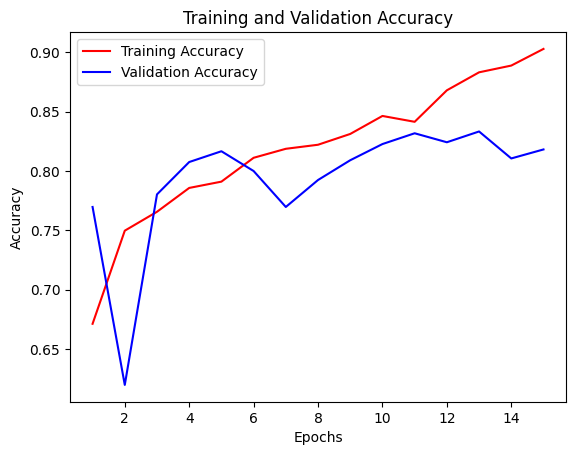

In [ ]:
# Accuracy 
performance_dict = history.history
accuracy_values = performance_dict["acc"]
val_accuracy_values = performance_dict["val_acc"]
epochs = range(1, len(accuracy_values) + 1)
plt.plot(epochs, accuracy_values, "b", label="Training Accuracy", color = 'red')
plt.plot(epochs, val_accuracy_values, "b", label="Validation Accuracy")
plt.title("Training and Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

<ipython-input-20-91741870ffcc>:5: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b" (-> color=(0.0, 0.0, 1.0, 1)). The keyword argument will take precedence.
  plt.plot(epochs, loss_values, "b", label="Training Loss", color = 'red')


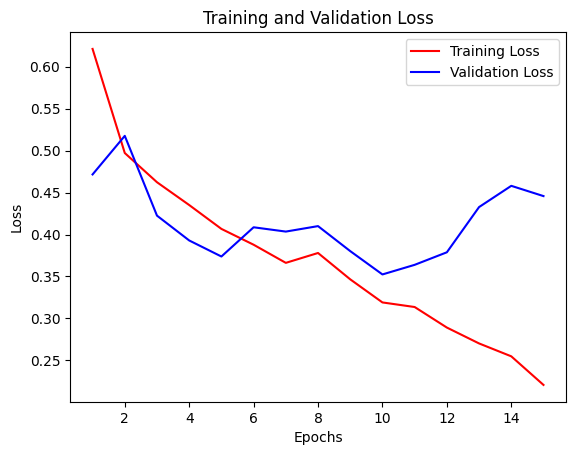

In [ ]:
performance_dict = history.history
loss_values = performance_dict["loss"]
val_loss_values = performance_dict["val_loss"]
epochs = range(1, len(loss_values) + 1)
plt.plot(epochs, loss_values, "b", label="Training Loss", color = 'red')
plt.plot(epochs, val_loss_values, "b", label="Validation Loss")
plt.title("Training and Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

# Repeating Steps Above with Sigmoid Activation Function

In [ ]:
# Our input feature map is 150x150x3: 150x150 for the image pixels, and 3 for the three color channels: R, G, and B
img_input = layers.Input(shape=(150, 150, 3))

# First convolution extracts 16 filters that are 3x3
# Convolution is followed by max-pooling layer with a 2x2 window
x = layers.Conv2D(16, 3, activation='sigmoid')(img_input)
x = layers.MaxPooling2D(2)(x)

# Second convolution extracts 32 filters that are 3x3
# Convolution is followed by max-pooling layer with a 2x2 window
x = layers.Conv2D(32, 3, activation='sigmoid')(x)
x = layers.MaxPooling2D(2)(x)

# Third convolution extracts 64 filters that are 3x3
# Convolution is followed by max-pooling layer with a 2x2 window
x = layers.Conv2D(64, 3, activation='sigmoid')(x)
x = layers.MaxPooling2D(2)(x)

In [ ]:
# Flatten feature map to a 1-dim tensor so we can add fully connected layers
x = layers.Flatten()(x)

# Create a fully connected layer with ReLU activation and 512 hidden units
x = layers.Dense(512, activation='sigmoid')(x)

# Create output layer with a single node and sigmoid activation
output = layers.Dense(1, activation='sigmoid')(x)

# Create model:
# input = input feature map
# output = input feature map + stacked convolution/maxpooling layers + fully 
# connected layer + sigmoid output layer
model_sigmoid = Model(img_input, output)

In [ ]:
model_sigmoid.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 conv2d_3 (Conv2D)           (None, 148, 148, 16)      448       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 74, 74, 16)       0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 72, 72, 32)        4640      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 36, 36, 32)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 34, 34, 64)        1849

In [ ]:
# All images will be rescaled by 1./255
train_datagen = ImageDataGenerator(rescale=1./255)
val_datagen = ImageDataGenerator(rescale=1./255)

# Flow training images in batches of 20 using train_datagen generator
train_generator = train_datagen.flow_from_directory(
        train_dir,  # This is the source directory for training images
        target_size=(150, 150),  # All images will be resized to 150x150
        batch_size=20,
        # Since we use binary_crossentropy loss, we need binary labels
        class_mode='binary')

# Flow validation images in batches of 20 using val_datagen generator
validation_generator = val_datagen.flow_from_directory(
        validation_dir,
        target_size=(150, 150),
        batch_size=20,
        class_mode='binary')

Found 2637 images belonging to 2 classes.
Found 660 images belonging to 2 classes.


In [ ]:
history_sigmoid = model.fit(
      train_generator,
      steps_per_epoch=None, 
      epochs=15,
      validation_data=validation_generator,
      validation_steps=None, 
      verbose=2)

Epoch 1/15
132/132 - 86s - loss: 0.1905 - acc: 0.9261 - val_loss: 0.7506 - val_acc: 0.7864 - 86s/epoch - 650ms/step
Epoch 2/15
132/132 - 79s - loss: 0.1759 - acc: 0.9302 - val_loss: 0.4961 - val_acc: 0.8227 - 79s/epoch - 602ms/step
Epoch 3/15
132/132 - 87s - loss: 0.1671 - acc: 0.9355 - val_loss: 0.5720 - val_acc: 0.8530 - 87s/epoch - 655ms/step
Epoch 4/15
132/132 - 79s - loss: 0.1304 - acc: 0.9488 - val_loss: 0.5459 - val_acc: 0.8470 - 79s/epoch - 600ms/step
Epoch 5/15
132/132 - 86s - loss: 0.1199 - acc: 0.9568 - val_loss: 0.6596 - val_acc: 0.8106 - 86s/epoch - 650ms/step
Epoch 6/15
132/132 - 84s - loss: 0.1055 - acc: 0.9655 - val_loss: 0.6249 - val_acc: 0.8470 - 84s/epoch - 639ms/step
Epoch 7/15
132/132 - 80s - loss: 0.0837 - acc: 0.9689 - val_loss: 0.7182 - val_acc: 0.8364 - 80s/epoch - 607ms/step
Epoch 8/15
132/132 - 87s - loss: 0.0650 - acc: 0.9788 - val_loss: 0.7516 - val_acc: 0.8364 - 87s/epoch - 661ms/step
Epoch 9/15
132/132 - 86s - loss: 0.1321 - acc: 0.9689 - val_loss: 0.8175

1/1 [==============================] - 0s 108ms/step


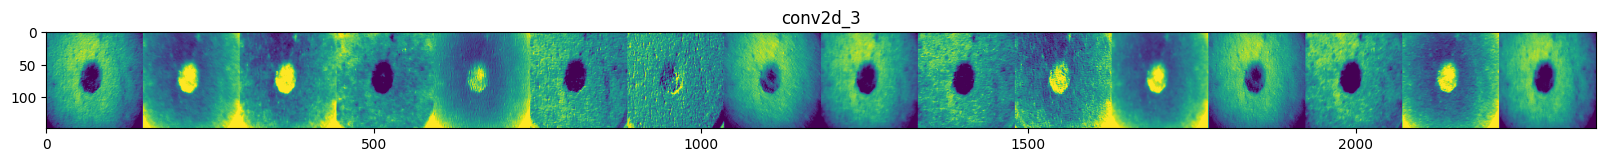

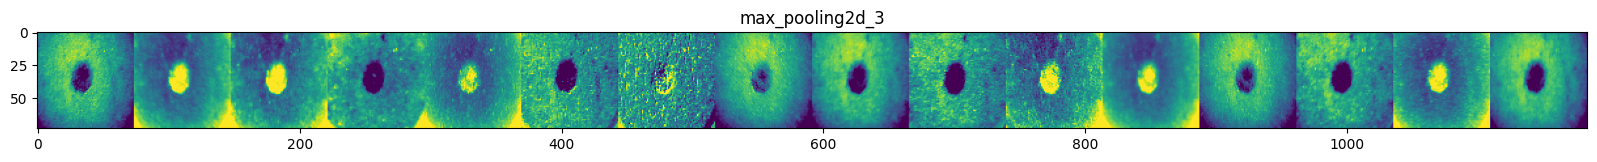

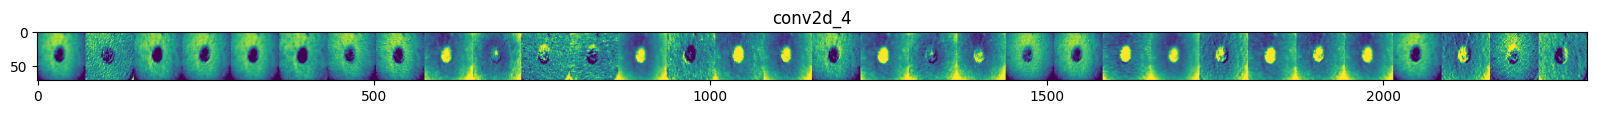

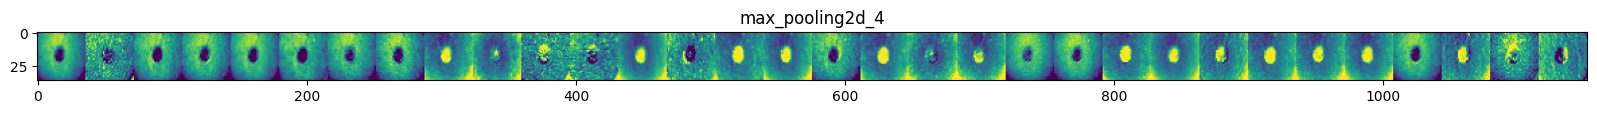

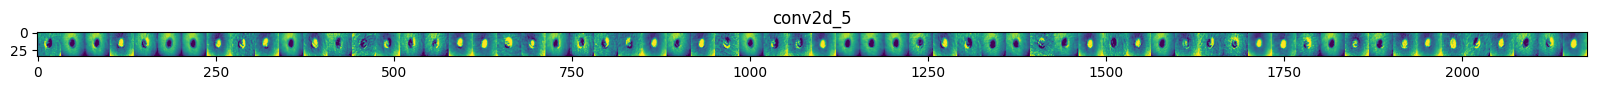

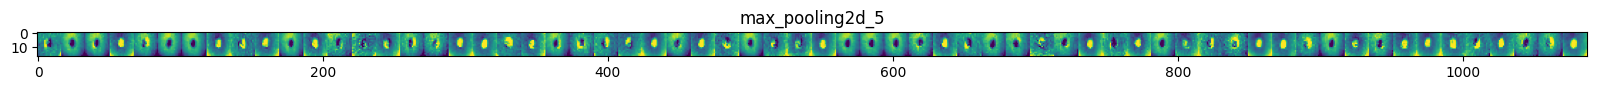

In [ ]:
# Let's define a new Model that will take an image as input, and will output
# intermediate representations for all layers in the previous model after
# the first.
successive_outputs = [layer.output for layer in model_sigmoid.layers[1:]]
visualization_model = Model(img_input, successive_outputs)

# Let's prepare a random input image of a malignant or benign tumor from the training set.
malignant_img_files = [os.path.join(train_malignant_dir, f) for f in train_malignant_fnames]
benign_img_files = [os.path.join(train_benign_dir, f) for f in train_benign_fnames]
img_path = random.choice(malignant_img_files + benign_img_files)

img = load_img(img_path, target_size=(150, 150))  # this is a PIL image
x = img_to_array(img)  # Numpy array with shape (150, 150, 3)
x = x.reshape((1,) + x.shape)  # Numpy array with shape (1, 150, 150, 3)

# Rescale by 1/255
x /= 255

# Let's run our image through our network, thus obtaining all
# intermediate representations for this image.
successive_feature_maps = visualization_model.predict(x)

# These are the names of the layers, so can have them as part of our plot
layer_names = [layer.name for layer in model_sigmoid.layers[1:]]

# Now let's display our representations
for layer_name, feature_map in zip(layer_names, successive_feature_maps):
  if len(feature_map.shape) == 4:
    # Just do this for the conv / maxpool layers, not the fully-connected layers
    n_features = feature_map.shape[-1]  # number of features in feature map
    # The feature map has shape (1, size, size, n_features)
    size = feature_map.shape[1]
    # We will tile our images in this matrix
    display_grid = np.zeros((size, size * n_features))
    for i in range(n_features):
      # Postprocess the feature to make it visually palatable
      x = feature_map[0, :, :, i]
      x -= x.mean()
      x /= x.std()
      x *= 64
      x += 128
      x = np.clip(x, 0, 255).astype('uint8')
      # We'll tile each filter into this big horizontal grid
      display_grid[:, i * size : (i + 1) * size] = x
    # Display the grid
    scale = 20. / n_features
    plt.figure(figsize=(scale * n_features, scale))
    plt.title(layer_name)
    plt.grid(False)
    plt.imshow(display_grid, aspect='auto', cmap='viridis')

<ipython-input-27-e3bca0e6c8c8>:6: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b" (-> color=(0.0, 0.0, 1.0, 1)). The keyword argument will take precedence.
  plt.plot(epochs, accuracy_values_sigmoid, "b", label="Training Accuracy", color = 'red')


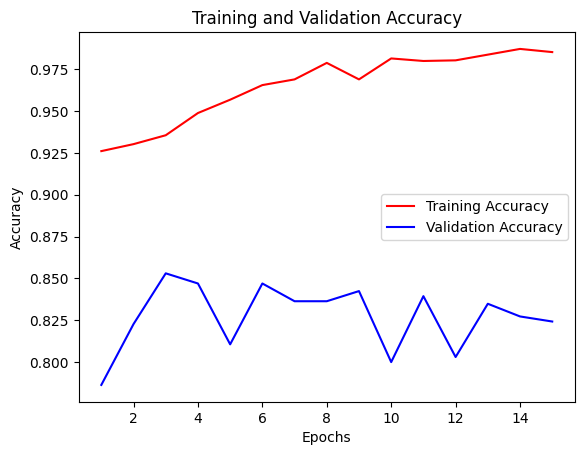

In [ ]:
# Accuracy 
performance_dict_sigmoid = history_sigmoid.history
accuracy_values_sigmoid = performance_dict_sigmoid["acc"]
val_accuracy_values_sigmoid = performance_dict_sigmoid["val_acc"]
epochs = range(1, len(accuracy_values_sigmoid) + 1)
plt.plot(epochs, accuracy_values_sigmoid, "b", label="Training Accuracy", color = 'red')
plt.plot(epochs, val_accuracy_values_sigmoid, "b", label="Validation Accuracy")
plt.title("Training and Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

<ipython-input-28-84fb18421a11>:6: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b" (-> color=(0.0, 0.0, 1.0, 1)). The keyword argument will take precedence.
  plt.plot(epochs, loss_values_sigmoid, "b", label="Training Loss", color = 'red')


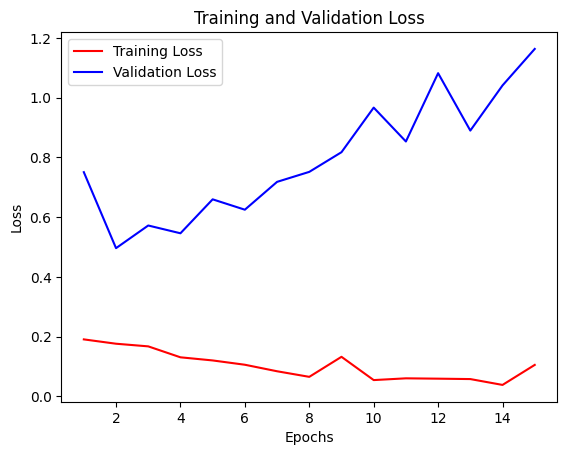

In [ ]:
# Loss
performance_dict_sigmoid = history_sigmoid.history
loss_values_sigmoid = performance_dict_sigmoid["loss"]
val_loss_values_sigmoid = performance_dict_sigmoid["val_loss"]
epochs = range(1, len(loss_values_sigmoid) + 1)
plt.plot(epochs, loss_values_sigmoid, "b", label="Training Loss", color = 'red')
plt.plot(epochs, val_loss_values_sigmoid, "b", label="Validation Loss")
plt.title("Training and Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

# First Model Accuracy and Loss Results

<ipython-input-33-9525f1dacfdd>:11: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b" (-> color=(0.0, 0.0, 1.0, 1)). The keyword argument will take precedence.
  axs[0, 0].plot(epochs, accuracy_values, "b", label="Training Accuracy", color = 'red')
<ipython-input-33-9525f1dacfdd>:18: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b" (-> color=(0.0, 0.0, 1.0, 1)). The keyword argument will take precedence.
  axs[0, 1].plot(epochs, loss_values, "b", label="Training Loss", color = 'red')
<ipython-input-33-9525f1dacfdd>:34: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b" (-> color=(0.0, 0.0, 1.0, 1)). The keyword argument will take precedence.
  axs[1, 0].plot(epochs, accuracy_values_sigmoid, "b", label="Training Accuracy", color = 'red')
<ipython-input-33-9525f1dacfdd>:41: UserWarning: color is redundantly defined by the 'color' keyword argument an

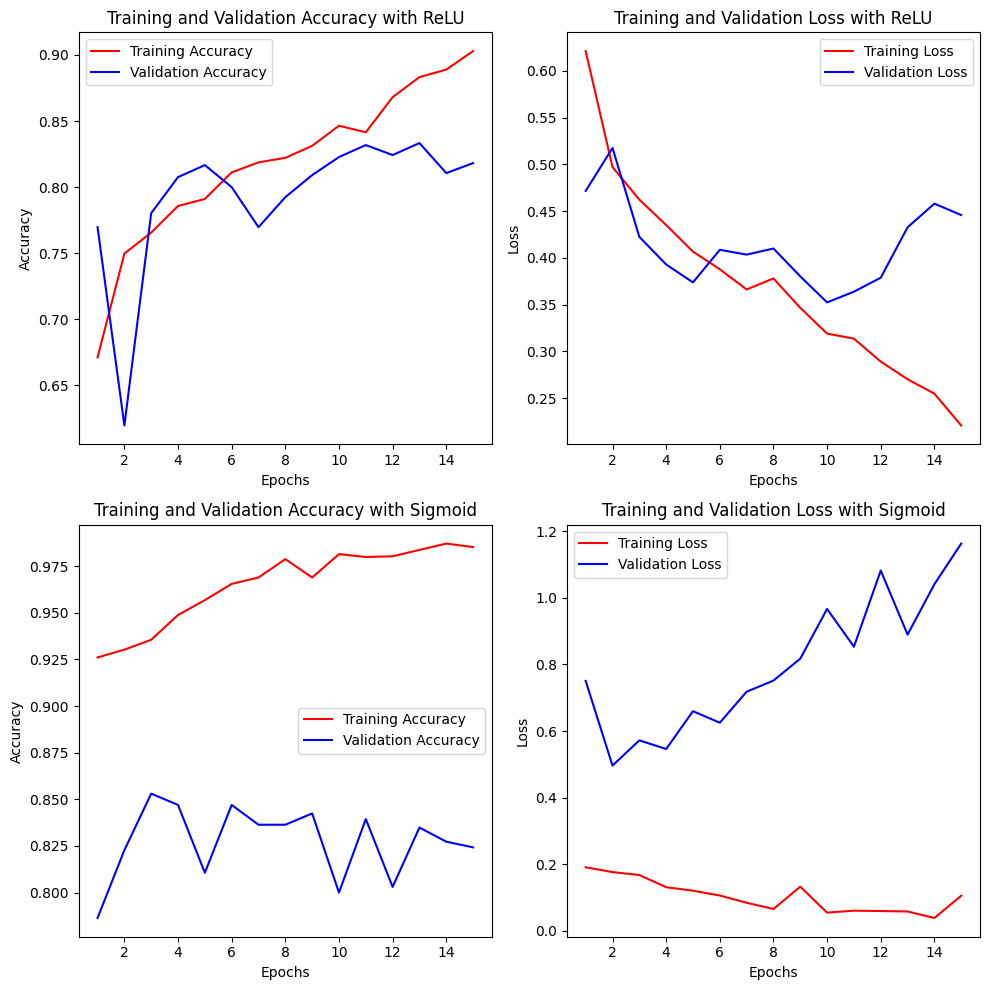

In [ ]:
# Plot for the first model
performance_dict = history.history
accuracy_values = performance_dict["acc"]
val_accuracy_values = performance_dict["val_acc"]
loss_values = performance_dict["loss"]
val_loss_values = performance_dict["val_loss"]
epochs = range(1, len(accuracy_values) + 1)

fig, axs = plt.subplots(2, 2, figsize=(10,10))

axs[0, 0].plot(epochs, accuracy_values, "b", label="Training Accuracy", color = 'red')
axs[0, 0].plot(epochs, val_accuracy_values, "b", label="Validation Accuracy")
axs[0, 0].set_title("Training and Validation Accuracy with ReLU")
axs[0, 0].set_xlabel("Epochs")
axs[0, 0].set_ylabel("Accuracy")
axs[0, 0].legend()

axs[0, 1].plot(epochs, loss_values, "b", label="Training Loss", color = 'red')
axs[0, 1].plot(epochs, val_loss_values, "b", label="Validation Loss")
axs[0, 1].set_title("Training and Validation Loss with ReLU")
axs[0, 1].set_xlabel("Epochs")
axs[0, 1].set_ylabel("Loss")
axs[0, 1].legend()


# Plot for the second model
performance_dict_sigmoid = history_sigmoid.history
accuracy_values_sigmoid = performance_dict_sigmoid["acc"]
val_accuracy_values_sigmoid = performance_dict_sigmoid["val_acc"]
loss_values_sigmoid = performance_dict_sigmoid["loss"]
val_loss_values_sigmoid = performance_dict_sigmoid["val_loss"]
epochs = range(1, len(accuracy_values_sigmoid) + 1)

axs[1, 0].plot(epochs, accuracy_values_sigmoid, "b", label="Training Accuracy", color = 'red')
axs[1, 0].plot(epochs, val_accuracy_values_sigmoid, "b", label="Validation Accuracy")
axs[1, 0].set_title("Training and Validation Accuracy with Sigmoid")
axs[1, 0].set_xlabel("Epochs")
axs[1, 0].set_ylabel("Accuracy")
axs[1, 0].legend()

axs[1, 1].plot(epochs, loss_values_sigmoid, "b", label="Training Loss", color = 'red')
axs[1, 1].plot(epochs, val_loss_values_sigmoid, "b", label="Validation Loss")
axs[1, 1].set_title("Training and Validation Loss with Sigmoid")
axs[1, 1].set_xlabel("Epochs")
axs[1, 1].set_ylabel("Loss")
axs[1, 1].legend()

plt.tight_layout()
plt.show()

# Reducing Overfitting
We will try to improve accuracy by employing a couple strategies to reduce overfitting: data augmentation and dropout. We will follow these steps: Explore how data augmentation works by making random transformations to training images. Add data augmentation to our data preprocessing. Add dropout to the convnet. Retrain the model and evaluate loss and accuracy. Let's get started!

Exploring Data Augmentation: Let's get familiar with the concept of data augmentation, an essential way to fight overfitting for computer vision models.

In order to make the most of our few training examples, we will "augment" them via a number of random transformations, so that at training time, our model will never see the exact same picture twice. This helps prevent overfitting and helps the model generalize better.

This can be done by configuring a number of random transformations to be performed on the images read by our ImageDataGenerator instance. Let's get started with an example:

# Data Augmentation

In [ ]:
datagen = ImageDataGenerator(
      rotation_range=40,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest')

Let's take a look at our augmented images.

Let's apply the datagen transformations to a  image from the training set to produce five random variants. Rerun the cell a few times to see fresh batches of random variants.

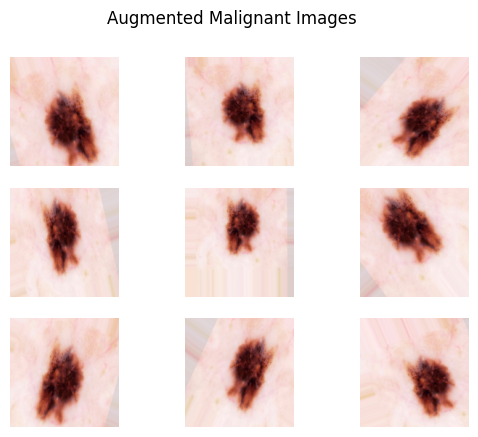

In [ ]:
%matplotlib inline
img_path = os.path.join(train_malignant_dir, train_malignant_fnames[2])
img = load_img(img_path, target_size=(150, 150))  # this is a PIL image
x = img_to_array(img)  # Numpy array with shape (150, 150, 3)
x = x.reshape((1,) + x.shape)  # Numpy array with shape (1, 150, 150, 3)

# The .flow() command below generates batches of randomly transformed images
# It will loop indefinitely, so we need to `break` the loop at some point!
i = 0
for batch in datagen.flow(x, batch_size=1):
  plt.subplot(3,3,i+1)
  plt.axis("off")
  plt.suptitle("Augmented Malignant Images")
  imgplot = plt.imshow(array_to_img(batch[0]))
  i += 1
  if i % 9 == 0:
    break

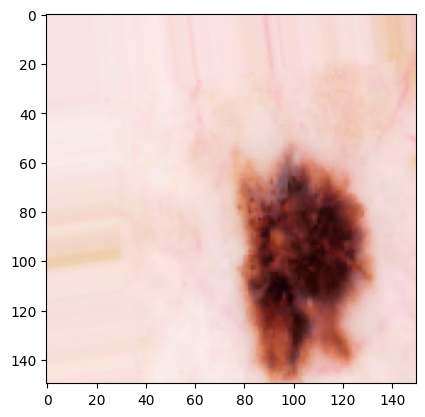

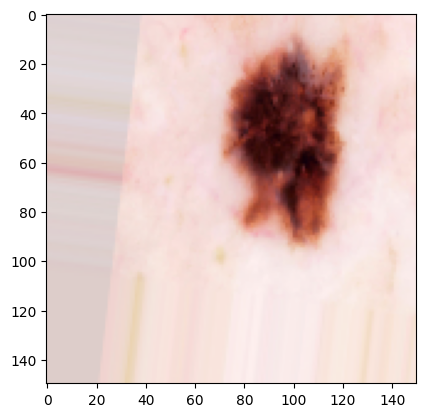

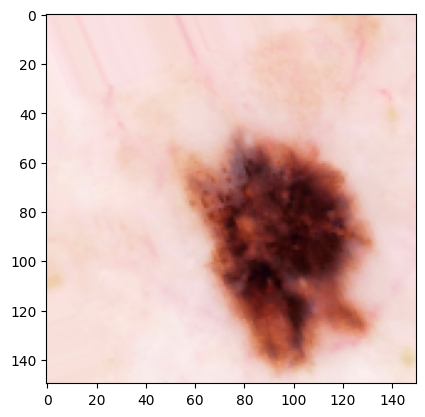

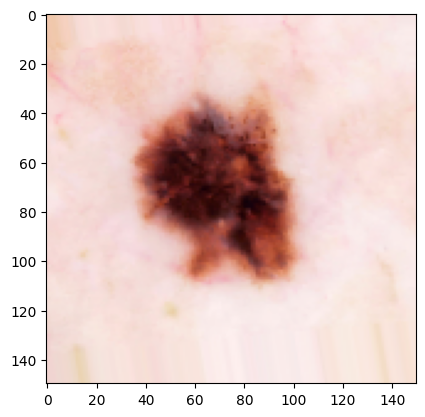

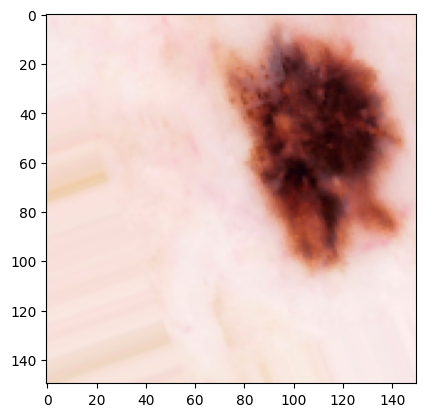

In [ ]:
%matplotlib inline
img_path = os.path.join(train_malignant_dir, train_malignant_fnames[2])
img = load_img(img_path, target_size=(150, 150))  # this is a PIL image
x = img_to_array(img)  # Numpy array with shape (150, 150, 3)
x = x.reshape((1,) + x.shape)  # Numpy array with shape (1, 150, 150, 3)

# The .flow() command below generates batches of randomly transformed images
# It will loop indefinitely, so we need to `break` the loop at some point!
i = 0
for batch in datagen.flow(x, batch_size=1):
  plt.figure(i)
  imgplot = plt.imshow(array_to_img(batch[0]))
  i += 1
  if i % 5 == 0:
    break

Add Data Augmentation to the Preprocessing Step
Now let's add our data-augmentation transformations from Exploring Data Augmentation to our data preprocessing configuration:

In [ ]:
# Adding rescale, rotation_range, width_shift_range, height_shift_range,
# shear_range, zoom_range, and horizontal flip to our ImageDataGenerator
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,)

# Note that the validation data should not be augmented!
val_datagen = ImageDataGenerator(rescale=1./255)

# Flow training images in batches of 32 using train_datagen generator
train_generator = train_datagen.flow_from_directory(
        train_dir,  # This is the source directory for training images
        target_size=(150, 150),  # All images will be resized to 150x150
        batch_size=20,
        # Since we use binary_crossentropy loss, we need binary labels
        class_mode='binary')

# Flow validation images in batches of 32 using val_datagen generator
validation_generator = val_datagen.flow_from_directory(
        validation_dir,
        target_size=(150, 150),
        batch_size=20,
        class_mode='binary')

Found 2637 images belonging to 2 classes.
Found 660 images belonging to 2 classes.


If we train a new network using this data augmentation configuration, our network will never see the same input twice. However the inputs that it sees are still heavily intercorrelated, so this might not be quite enough to completely get rid of overfitting.

# Adding Dropout
Another popular strategy for fighting overfitting is to use dropout.

In [ ]:
#ReLU

# Our input feature map is 150x150x3: 150x150 for the image pixels, and 3 for
# the three color channels: R, G, and B
img_input = layers.Input(shape=(150, 150, 3))

# First convolution extracts 16 filters that are 3x3
# Convolution is followed by max-pooling layer with a 2x2 window
x = layers.Conv2D(16, 3, activation='relu')(img_input)
x = layers.MaxPooling2D(2)(x)

# Second convolution extracts 32 filters that are 3x3
# Convolution is followed by max-pooling layer with a 2x2 window
x = layers.Conv2D(32, 3, activation='relu')(x)
x = layers.MaxPooling2D(2)(x)

# Third convolution extracts 64 filters that are 3x3
# Convolution is followed by max-pooling layer with a 2x2 window
x = layers.Convolution2D(64, 3, activation='relu')(x)
x = layers.MaxPooling2D(2)(x)

# Flatten feature map to a 1-dim tensor
x = layers.Flatten()(x)

# Create a fully connected layer with ReLU activation and 512 hidden units - added dropout
x = layers.Dense(512, activation='relu')(x)

# Add a dropout rate of 0.5
x = layers.Dropout(0.5)(x)

# Create output layer with a single node and sigmoid activation
output = layers.Dense(1, activation='sigmoid')(x)

# Configure and compile the model
model = Model(img_input, output)
model.compile(loss='binary_crossentropy',
              optimizer=RMSprop(lr=0.001),
              metrics=['acc'])

# Retrain the Model
With data augmentation and dropout in place, let's retrain our convnet model. This time, let's train on all 2,637 images available, for 15 epochs, and validate on all 660 validation images.

In [ ]:
history = model.fit(
      train_generator,
      steps_per_epoch=None,
      epochs=15,
      validation_data=validation_generator,
      validation_steps=None,
      verbose=2)

Epoch 1/15
132/132 - 106s - loss: 0.6368 - acc: 0.6390 - val_loss: 0.4815 - val_acc: 0.7591 - 106s/epoch - 802ms/step
Epoch 2/15
132/132 - 92s - loss: 0.5322 - acc: 0.7345 - val_loss: 0.4017 - val_acc: 0.7818 - 92s/epoch - 700ms/step
Epoch 3/15
132/132 - 95s - loss: 0.4906 - acc: 0.7573 - val_loss: 0.4838 - val_acc: 0.7379 - 95s/epoch - 721ms/step
Epoch 4/15
132/132 - 95s - loss: 0.4791 - acc: 0.7687 - val_loss: 0.3973 - val_acc: 0.7864 - 95s/epoch - 718ms/step
Epoch 5/15
132/132 - 92s - loss: 0.4502 - acc: 0.7880 - val_loss: 0.6544 - val_acc: 0.6091 - 92s/epoch - 700ms/step
Epoch 6/15
132/132 - 91s - loss: 0.4479 - acc: 0.7892 - val_loss: 0.4062 - val_acc: 0.7985 - 91s/epoch - 689ms/step
Epoch 7/15
132/132 - 92s - loss: 0.4374 - acc: 0.7816 - val_loss: 0.4599 - val_acc: 0.7955 - 92s/epoch - 700ms/step
Epoch 8/15
132/132 - 94s - loss: 0.4434 - acc: 0.7990 - val_loss: 0.3810 - val_acc: 0.8136 - 94s/epoch - 711ms/step
Epoch 9/15
132/132 - 92s - loss: 0.4303 - acc: 0.7960 - val_loss: 0.38

Note that with data augmentation in place, the 2,637 training images are randomly transformed each time a new training epoch runs, which means that the model will never see the same image twice during training.

# Evaluate the Results
Let's evaluate the results of model training with data augmentation and dropout:

<ipython-input-40-ebf5d7f82cb7>:5: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b" (-> color=(0.0, 0.0, 1.0, 1)). The keyword argument will take precedence.
  plt.plot(epochs, accuracy_values, "b", label="Training Accuracy", color = 'red')


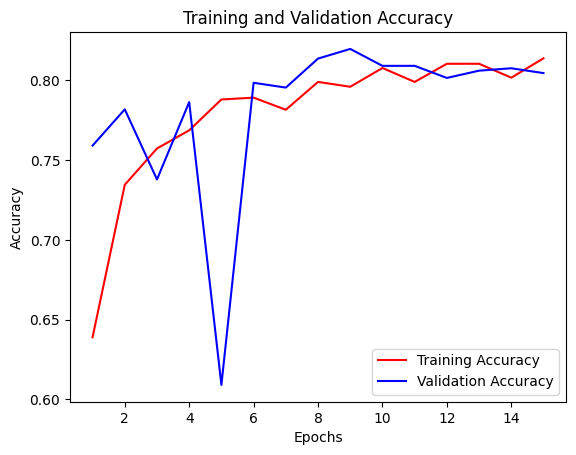

In [ ]:
performance_dict = history.history
accuracy_values = performance_dict["acc"]
val_accuracy_values = performance_dict["val_acc"]
epochs = range(1, len(loss_values) + 1)
plt.plot(epochs, accuracy_values, "b", label="Training Accuracy", color = 'red')
plt.plot(epochs, val_accuracy_values, "b", label="Validation Accuracy")
plt.title("Training and Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

<ipython-input-41-91741870ffcc>:5: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b" (-> color=(0.0, 0.0, 1.0, 1)). The keyword argument will take precedence.
  plt.plot(epochs, loss_values, "b", label="Training Loss", color = 'red')


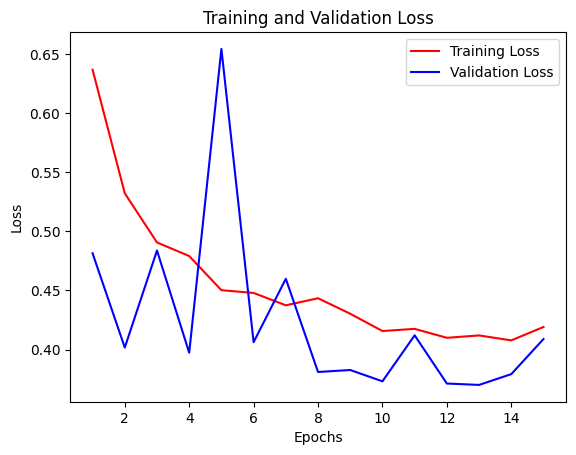

In [ ]:
performance_dict = history.history
loss_values = performance_dict["loss"]
val_loss_values = performance_dict["val_loss"]
epochs = range(1, len(loss_values) + 1)
plt.plot(epochs, loss_values, "b", label="Training Loss", color = 'red')
plt.plot(epochs, val_loss_values, "b", label="Validation Loss")
plt.title("Training and Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

# Repeating steps above with Sigmoid Activation Function

In [ ]:
#Sigmoid

# Our input feature map is 150x150x3: 150x150 for the image pixels, and 3 for
# the three color channels: R, G, and B
img_input = layers.Input(shape=(150, 150, 3))

# First convolution extracts 16 filters that are 3x3
# Convolution is followed by max-pooling layer with a 2x2 window
x = layers.Conv2D(16, 3, activation='sigmoid')(img_input)
x = layers.MaxPooling2D(2)(x)

# Second convolution extracts 32 filters that are 3x3
# Convolution is followed by max-pooling layer with a 2x2 window
x = layers.Conv2D(32, 3, activation='sigmoid')(x)
x = layers.MaxPooling2D(2)(x)

# Third convolution extracts 64 filters that are 3x3
# Convolution is followed by max-pooling layer with a 2x2 window
x = layers.Convolution2D(64, 3, activation='sigmoid')(x)
x = layers.MaxPooling2D(2)(x)

# Flatten feature map to a 1-dim tensor
x = layers.Flatten()(x)

# Create a fully connected layer with ReLU activation and 512 hidden units - only adding dropout to this layer!
x = layers.Dense(512, activation='sigmoid')(x)

# Add a dropout rate of 0.5
x = layers.Dropout(0.5)(x)

# Create output layer with a single node and sigmoid activation
output = layers.Dense(1, activation='sigmoid')(x)

# Configure and compile the model
model_sigmoid_dropout = Model(img_input, output)
model_sigmoid_dropout.compile(loss='binary_crossentropy',
              optimizer=RMSprop(lr=0.001),
              metrics=['accuracy'])

In [ ]:
history_sigmoid_dropout = model_sigmoid_dropout.fit(
      train_generator,
      steps_per_epoch=None,
      epochs=15,
      validation_data=validation_generator,
      validation_steps=None,
      verbose=2)

Epoch 1/15
132/132 - 101s - loss: 0.7987 - accuracy: 0.5146 - val_loss: 0.6982 - val_accuracy: 0.4545 - 101s/epoch - 763ms/step
Epoch 2/15
132/132 - 98s - loss: 0.7675 - accuracy: 0.5154 - val_loss: 0.7199 - val_accuracy: 0.5455 - 98s/epoch - 741ms/step
Epoch 3/15
132/132 - 99s - loss: 0.7652 - accuracy: 0.4941 - val_loss: 0.6985 - val_accuracy: 0.5455 - 99s/epoch - 747ms/step
Epoch 4/15
132/132 - 98s - loss: 0.7340 - accuracy: 0.5066 - val_loss: 0.6895 - val_accuracy: 0.5455 - 98s/epoch - 739ms/step
Epoch 5/15
132/132 - 101s - loss: 0.7363 - accuracy: 0.4937 - val_loss: 0.7026 - val_accuracy: 0.5455 - 101s/epoch - 765ms/step
Epoch 6/15
132/132 - 105s - loss: 0.7156 - accuracy: 0.5218 - val_loss: 0.6901 - val_accuracy: 0.5455 - 105s/epoch - 797ms/step
Epoch 7/15
132/132 - 103s - loss: 0.7133 - accuracy: 0.5165 - val_loss: 0.6934 - val_accuracy: 0.5455 - 103s/epoch - 783ms/step
Epoch 8/15
132/132 - 101s - loss: 0.7084 - accuracy: 0.5112 - val_loss: 0.6913 - val_accuracy: 0.5455 - 101s/e

<ipython-input-44-18c0191afdb6>:5: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b" (-> color=(0.0, 0.0, 1.0, 1)). The keyword argument will take precedence.
  plt.plot(epochs, accuracy_values, "b", label="Training Accuracy", color = 'red')


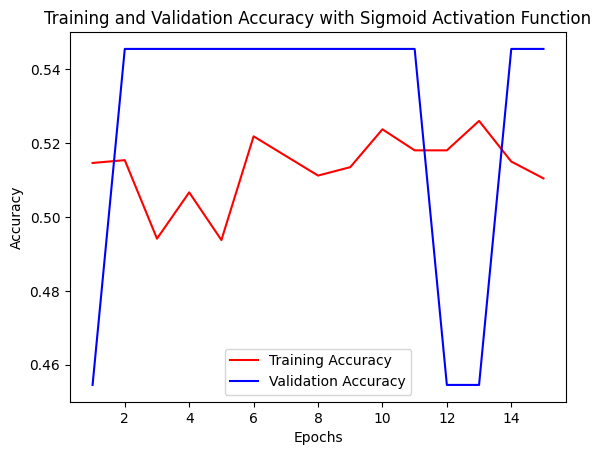

In [ ]:
performance_dict = history_sigmoid_dropout.history
accuracy_values = performance_dict["accuracy"]
val_accuracy_values = performance_dict["val_accuracy"]
epochs = range(1, len(loss_values) + 1)
plt.plot(epochs, accuracy_values, "b", label="Training Accuracy", color = 'red')
plt.plot(epochs, val_accuracy_values, "b", label="Validation Accuracy")
plt.title("Training and Validation Accuracy with Sigmoid Activation Function")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

<ipython-input-45-5486e1c78978>:5: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b" (-> color=(0.0, 0.0, 1.0, 1)). The keyword argument will take precedence.
  plt.plot(epochs, loss_values, "b", label="Training Loss", color = 'red')


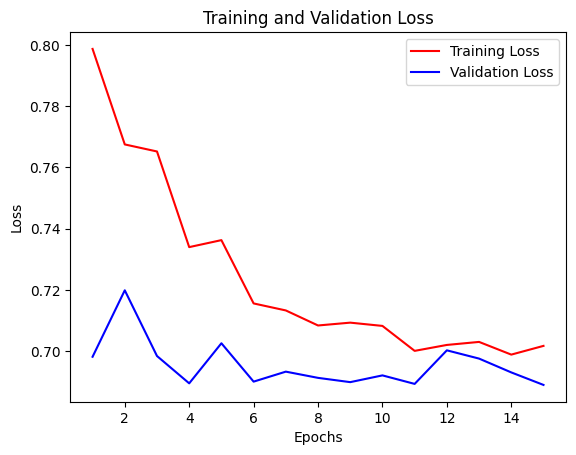

In [ ]:
performance_dict = history_sigmoid_dropout.history
loss_values = performance_dict["loss"]
val_loss_values = performance_dict["val_loss"]
epochs = range(1, len(loss_values) + 1)
plt.plot(epochs, loss_values, "b", label="Training Loss", color = 'red')
plt.plot(epochs, val_loss_values, "b", label="Validation Loss")
plt.title("Training and Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

# Second Model Accuracy and Loss Results

<ipython-input-46-27d50f69120c>:11: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b" (-> color=(0.0, 0.0, 1.0, 1)). The keyword argument will take precedence.
  axs[0, 0].plot(epochs, accuracy_values, "b", label="Training Accuracy", color = 'red')
<ipython-input-46-27d50f69120c>:18: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b" (-> color=(0.0, 0.0, 1.0, 1)). The keyword argument will take precedence.
  axs[0, 1].plot(epochs, loss_values, "b", label="Training Loss", color = 'red')
<ipython-input-46-27d50f69120c>:34: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b" (-> color=(0.0, 0.0, 1.0, 1)). The keyword argument will take precedence.
  axs[1, 0].plot(epochs, accuracy_values1, "b", label="Training Accuracy", color = 'red')
<ipython-input-46-27d50f69120c>:41: UserWarning: color is redundantly defined by the 'color' keyword argument and the f

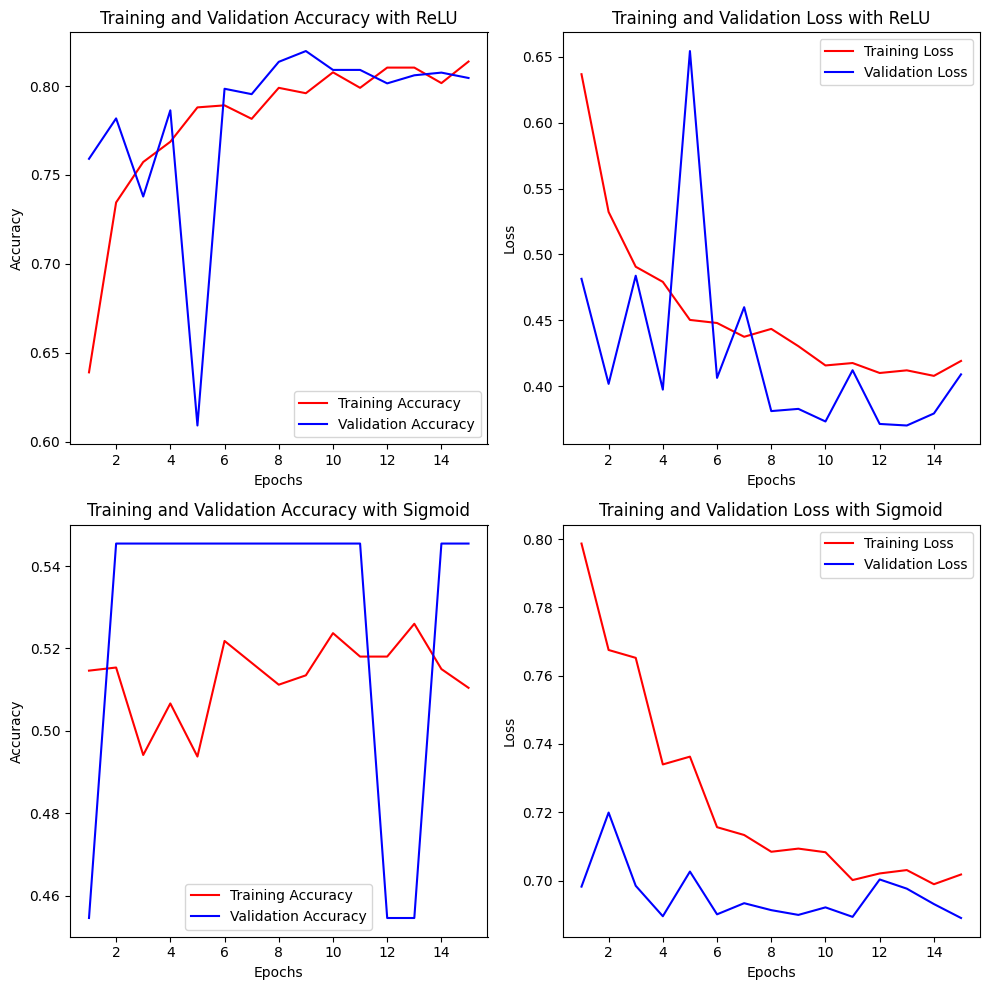

In [ ]:
# Plot for the first model
performance_dict = history.history
accuracy_values = performance_dict["acc"]
val_accuracy_values = performance_dict["val_acc"]
loss_values = performance_dict["loss"]
val_loss_values = performance_dict["val_loss"]
epochs = range(1, len(accuracy_values) + 1)

fig, axs = plt.subplots(2, 2, figsize=(10, 10))

axs[0, 0].plot(epochs, accuracy_values, "b", label="Training Accuracy", color = 'red')
axs[0, 0].plot(epochs, val_accuracy_values, "b", label="Validation Accuracy")
axs[0, 0].set_title("Training and Validation Accuracy with ReLU")
axs[0, 0].set_xlabel("Epochs")
axs[0, 0].set_ylabel("Accuracy")
axs[0, 0].legend()

axs[0, 1].plot(epochs, loss_values, "b", label="Training Loss", color = 'red')
axs[0, 1].plot(epochs, val_loss_values, "b", label="Validation Loss")
axs[0, 1].set_title("Training and Validation Loss with ReLU")
axs[0, 1].set_xlabel("Epochs")
axs[0, 1].set_ylabel("Loss")
axs[0, 1].legend()


# Plot for the second model
performance_dict1 = history_sigmoid_dropout.history
accuracy_values1 = performance_dict1["accuracy"]
val_accuracy_values1 = performance_dict1["val_accuracy"]
loss_values1 = performance_dict1["loss"]
val_loss_values1 = performance_dict1["val_loss"]
epochs = range(1, len(loss_values1) + 1)

axs[1, 0].plot(epochs, accuracy_values1, "b", label="Training Accuracy", color = 'red')
axs[1, 0].plot(epochs, val_accuracy_values1, "b", label="Validation Accuracy")
axs[1, 0].set_title("Training and Validation Accuracy with Sigmoid")
axs[1, 0].set_xlabel("Epochs")
axs[1, 0].set_ylabel("Accuracy")
axs[1, 0].legend()

axs[1, 1].plot(epochs, loss_values1, "b", label="Training Loss", color = 'red')
axs[1, 1].plot(epochs, val_loss_values1, "b", label="Validation Loss")
axs[1, 1].set_title("Training and Validation Loss with Sigmoid")
axs[1, 1].set_xlabel("Epochs")
axs[1, 1].set_ylabel("Loss")
axs[1, 1].legend()

plt.tight_layout()
plt.show()

# Residual Block

In [ ]:
# ReLU with Dropout of 0.2

inputs = tf.keras.Input(shape=(150, 150, 3))
x = tf.keras.layers.Rescaling(1/255)(inputs) # we rescale data             
def residual_block(x, filters, pooling=False):
    residual = x
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Conv2D(filters, 3, activation="relu", padding="same")(x) 
    
    if pooling:
       x = tf.keras.layers.MaxPooling2D(2, padding="same")(x)
       residual = tf.keras.layers.Conv2D(filters, 1, strides=2)(residual)
    elif filters != residual.shape[-1]:
       residual = tf.keras.layers.Conv2D(filters, 1)(residual)
       
    x = tf.keras.layers.add([x, residual]) 
       
    return x


x= residual_block(x, filters=64, pooling=True)
x = tf.keras.layers.Dropout(.2)(x)

x= residual_block(x, filters=64, pooling=True)
x = tf.keras.layers.Dropout(.2)(x)

x =residual_block(x, filters=64, pooling=True)
x = tf.keras.layers.Dropout(.2)(x)


x =residual_block(x, filters=16, pooling=False)

x = tf.keras.layers.Flatten()(x)  
x = tf.keras.layers.Dense(60, activation="relu")(x)

outputs = tf.keras.layers.Dense(1, activation="sigmoid")(x)

model_Residual_Block_with_dropout_ReLU = tf.keras.Model(inputs=inputs, outputs=outputs)
model_Residual_Block_with_dropout_ReLU.summary()

  # compile model
model_Residual_Block_with_dropout_ReLU.compile(loss= 'binary_crossentropy', optimizer=RMSprop(learning_rate=0.001), metrics=['accuracy'])

Model: "model_6"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 150, 150, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling (Rescaling)          (None, 150, 150, 3)  0           ['input_5[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 150, 150, 3)  12         ['rescaling[0][0]']              
 alization)                                                                                       
                                                                                            

In [ ]:
history_of_residualblock_withdropout_ReLU = model_Residual_Block_with_dropout_ReLU.fit(
      train_generator,
      steps_per_epoch=None,
      epochs=15,
      validation_data=validation_generator,
      validation_steps=None,
      verbose=2)

Epoch 1/15
132/132 - 304s - loss: 0.8834 - accuracy: 0.7110 - val_loss: 0.7023 - val_accuracy: 0.4545 - 304s/epoch - 2s/step
Epoch 2/15
132/132 - 292s - loss: 0.5320 - accuracy: 0.7455 - val_loss: 0.6945 - val_accuracy: 0.4545 - 292s/epoch - 2s/step
Epoch 3/15
132/132 - 288s - loss: 0.4643 - accuracy: 0.7763 - val_loss: 0.6957 - val_accuracy: 0.4545 - 288s/epoch - 2s/step
Epoch 4/15
132/132 - 283s - loss: 0.4633 - accuracy: 0.7797 - val_loss: 0.9385 - val_accuracy: 0.4545 - 283s/epoch - 2s/step
Epoch 5/15
132/132 - 282s - loss: 0.4621 - accuracy: 0.7717 - val_loss: 0.6741 - val_accuracy: 0.4742 - 282s/epoch - 2s/step
Epoch 6/15
132/132 - 277s - loss: 0.5037 - accuracy: 0.7766 - val_loss: 0.4621 - val_accuracy: 0.7712 - 277s/epoch - 2s/step
Epoch 7/15
132/132 - 283s - loss: 0.4403 - accuracy: 0.7793 - val_loss: 0.5338 - val_accuracy: 0.7576 - 283s/epoch - 2s/step
Epoch 8/15
132/132 - 280s - loss: 0.4286 - accuracy: 0.7808 - val_loss: 0.6601 - val_accuracy: 0.4970 - 280s/epoch - 2s/step


In [ ]:
# Sigmoid with Dropout of 0.2

inputs = tf.keras.Input(shape=(150, 150, 3))
x = tf.keras.layers.Rescaling(1/255)(inputs) # we rescale data             
def residual_block(x, filters, pooling=False):
    residual = x
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Conv2D(filters, 3, activation="sigmoid", padding="same")(x) 
    
    if pooling:
       x = tf.keras.layers.MaxPooling2D(2, padding="same")(x)
       residual = tf.keras.layers.Conv2D(filters, 1, strides=2)(residual)
    elif filters != residual.shape[-1]:
       residual = tf.keras.layers.Conv2D(filters, 1)(residual)
       
    x = tf.keras.layers.add([x, residual]) 
       
    return x


x= residual_block(x, filters=64, pooling=True)
x = tf.keras.layers.Dropout(.2)(x)

x= residual_block(x, filters=64, pooling=True)
x = tf.keras.layers.Dropout(.2)(x)

x =residual_block(x, filters=64, pooling=True)
x = tf.keras.layers.Dropout(.2)(x)


x =residual_block(x, filters=16, pooling=False)

x = tf.keras.layers.Flatten()(x)  
x = tf.keras.layers.Dense(60, activation="sigmoid")(x)

outputs = tf.keras.layers.Dense(1, activation="sigmoid")(x)

model_Residual_Block_with_dropout_sigmoid = tf.keras.Model(inputs=inputs, outputs=outputs)
model_Residual_Block_with_dropout_sigmoid.summary()

  # compile model
model_Residual_Block_with_dropout_sigmoid.compile(loss= 'binary_crossentropy', optimizer=RMSprop(learning_rate=0.001), metrics=['accuracy'])

Model: "model_7"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_6 (InputLayer)           [(None, 150, 150, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling_1 (Rescaling)        (None, 150, 150, 3)  0           ['input_6[0][0]']                
                                                                                                  
 batch_normalization_4 (BatchNo  (None, 150, 150, 3)  12         ['rescaling_1[0][0]']            
 rmalization)                                                                                     
                                                                                            

In [ ]:
history_residualblock_withdropout_sigmoid = model_Residual_Block_with_dropout_sigmoid.fit(
      train_generator,
      steps_per_epoch=None,
      epochs=15,
      validation_data=validation_generator,
      validation_steps=None,
      verbose=2)

Epoch 1/15
132/132 - 301s - loss: 0.6999 - accuracy: 0.5419 - val_loss: 0.6904 - val_accuracy: 0.5455 - 301s/epoch - 2s/step
Epoch 2/15
132/132 - 293s - loss: 0.6905 - accuracy: 0.5461 - val_loss: 0.6890 - val_accuracy: 0.5455 - 293s/epoch - 2s/step
Epoch 3/15
132/132 - 297s - loss: 0.6892 - accuracy: 0.5438 - val_loss: 0.6914 - val_accuracy: 0.5455 - 297s/epoch - 2s/step
Epoch 4/15
132/132 - 292s - loss: 0.6903 - accuracy: 0.5438 - val_loss: 0.6907 - val_accuracy: 0.5455 - 292s/epoch - 2s/step
Epoch 5/15
132/132 - 299s - loss: 0.6893 - accuracy: 0.5415 - val_loss: 0.6937 - val_accuracy: 0.5455 - 299s/epoch - 2s/step
Epoch 6/15
132/132 - 301s - loss: 0.6900 - accuracy: 0.5438 - val_loss: 0.6891 - val_accuracy: 0.5455 - 301s/epoch - 2s/step
Epoch 7/15
132/132 - 302s - loss: 0.6899 - accuracy: 0.5438 - val_loss: 0.6905 - val_accuracy: 0.5455 - 302s/epoch - 2s/step
Epoch 8/15
132/132 - 297s - loss: 0.6904 - accuracy: 0.5461 - val_loss: 0.6894 - val_accuracy: 0.5455 - 297s/epoch - 2s/step


In [ ]:
# Sigmoid

inputs = tf.keras.Input(shape=(150, 150, 3))
x = tf.keras.layers.Rescaling(1/255)(inputs) # we rescale data             
def residual_block(x, filters, pooling=False):
    residual = x
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Conv2D(filters, 3, activation="sigmoid", padding="same")(x) 
    
    if pooling:
       x = tf.keras.layers.MaxPooling2D(2, padding="same")(x)
       residual = tf.keras.layers.Conv2D(filters, 1, strides=2)(residual)
    elif filters != residual.shape[-1]:
       residual = tf.keras.layers.Conv2D(filters, 1)(residual)
       
    x = tf.keras.layers.add([x, residual]) 
       
    return x


x= residual_block(x, filters=64, pooling=True)

x= residual_block(x, filters=64, pooling=True)

x =residual_block(x, filters=64, pooling=True)

x =residual_block(x, filters=16, pooling=False)

x = tf.keras.layers.Flatten()(x)  
x = tf.keras.layers.Dense(60, activation="sigmoid")(x)

outputs = tf.keras.layers.Dense(1, activation="sigmoid")(x)

model_Residual_Block_without_dropout_sigmoid = tf.keras.Model(inputs=inputs, outputs=outputs)
model_Residual_Block_without_dropout_sigmoid.summary()

  # compile model
model_Residual_Block_without_dropout_sigmoid.compile(loss= 'binary_crossentropy', optimizer=RMSprop(learning_rate=0.001), metrics=['accuracy'])

Model: "model_8"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_7 (InputLayer)           [(None, 150, 150, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling_2 (Rescaling)        (None, 150, 150, 3)  0           ['input_7[0][0]']                
                                                                                                  
 batch_normalization_8 (BatchNo  (None, 150, 150, 3)  12         ['rescaling_2[0][0]']            
 rmalization)                                                                                     
                                                                                            

In [ ]:
history_residualblock_withoutdropout_sigmoid = model_Residual_Block_without_dropout_sigmoid.fit(
      train_generator,
      steps_per_epoch=None,
      epochs=15,
      validation_data=validation_generator,
      validation_steps=None,
      verbose=2)

Epoch 1/15
132/132 - 291s - loss: 0.6110 - accuracy: 0.7300 - val_loss: 0.8388 - val_accuracy: 0.4545 - 291s/epoch - 2s/step
Epoch 2/15
132/132 - 277s - loss: 0.4832 - accuracy: 0.7717 - val_loss: 0.8784 - val_accuracy: 0.4545 - 277s/epoch - 2s/step
Epoch 3/15
132/132 - 279s - loss: 0.4790 - accuracy: 0.7706 - val_loss: 1.1261 - val_accuracy: 0.5455 - 279s/epoch - 2s/step
Epoch 4/15
132/132 - 282s - loss: 0.4641 - accuracy: 0.7766 - val_loss: 0.9211 - val_accuracy: 0.5455 - 282s/epoch - 2s/step
Epoch 5/15
132/132 - 286s - loss: 0.4511 - accuracy: 0.7823 - val_loss: 0.8984 - val_accuracy: 0.5500 - 286s/epoch - 2s/step
Epoch 6/15
132/132 - 282s - loss: 0.4587 - accuracy: 0.7782 - val_loss: 0.6975 - val_accuracy: 0.6258 - 282s/epoch - 2s/step
Epoch 7/15
132/132 - 279s - loss: 0.4397 - accuracy: 0.7922 - val_loss: 1.5736 - val_accuracy: 0.5455 - 279s/epoch - 2s/step
Epoch 8/15
132/132 - 272s - loss: 0.4507 - accuracy: 0.7804 - val_loss: 0.7293 - val_accuracy: 0.6455 - 272s/epoch - 2s/step


In [ ]:
# ReLU 

inputs = tf.keras.Input(shape=(150, 150, 3))
x = tf.keras.layers.Rescaling(1/255)(inputs) # we rescale data             
def residual_block(x, filters, pooling=False):
    residual = x
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Conv2D(filters, 3, activation="relu", padding="same")(x) 
    
    if pooling:
       x = tf.keras.layers.MaxPooling2D(2, padding="same")(x)
       residual = tf.keras.layers.Conv2D(filters, 1, strides=2)(residual)
    elif filters != residual.shape[-1]:
       residual = tf.keras.layers.Conv2D(filters, 1)(residual)
       
    x = tf.keras.layers.add([x, residual]) 
       
    return x


x= residual_block(x, filters=64, pooling=True)

x= residual_block(x, filters=64, pooling=True)

x =residual_block(x, filters=64, pooling=True)

x =residual_block(x, filters=16, pooling=False)

x = tf.keras.layers.Flatten()(x)  
x = tf.keras.layers.Dense(60, activation="relu")(x)

outputs = tf.keras.layers.Dense(1, activation="relu")(x)

model_Residual_Block_without_dropout_ReLU = tf.keras.Model(inputs=inputs, outputs=outputs)
model_Residual_Block_without_dropout_ReLU.summary()

  # compile model
model_Residual_Block_without_dropout_ReLU.compile(loss= 'binary_crossentropy', optimizer=RMSprop(learning_rate=0.001), metrics=['accuracy'])

Model: "model_9"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_8 (InputLayer)           [(None, 150, 150, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling_3 (Rescaling)        (None, 150, 150, 3)  0           ['input_8[0][0]']                
                                                                                                  
 batch_normalization_12 (BatchN  (None, 150, 150, 3)  12         ['rescaling_3[0][0]']            
 ormalization)                                                                                    
                                                                                            

In [ ]:
history_residualblock_withoutdropout_ReLU = model_Residual_Block_without_dropout_ReLU.fit(
      train_generator,
      steps_per_epoch=None,
      epochs=15,
      validation_data=validation_generator,
      validation_steps=None,
      verbose=2)

Epoch 1/15
132/132 - 278s - loss: 7.1767 - accuracy: 0.5324 - val_loss: 7.0113 - val_accuracy: 0.5455 - 278s/epoch - 2s/step
Epoch 2/15
132/132 - 266s - loss: 6.5837 - accuracy: 0.5715 - val_loss: 7.0113 - val_accuracy: 0.5455 - 266s/epoch - 2s/step
Epoch 3/15
132/132 - 266s - loss: 6.4857 - accuracy: 0.5791 - val_loss: 7.0113 - val_accuracy: 0.5455 - 266s/epoch - 2s/step
Epoch 4/15
132/132 - 267s - loss: 6.8850 - accuracy: 0.5533 - val_loss: 7.0113 - val_accuracy: 0.5455 - 267s/epoch - 2s/step
Epoch 5/15
132/132 - 268s - loss: 7.0018 - accuracy: 0.5461 - val_loss: 7.0113 - val_accuracy: 0.5455 - 268s/epoch - 2s/step
Epoch 6/15
132/132 - 272s - loss: 7.0018 - accuracy: 0.5461 - val_loss: 7.0113 - val_accuracy: 0.5455 - 272s/epoch - 2s/step
Epoch 7/15
132/132 - 269s - loss: 7.0018 - accuracy: 0.5461 - val_loss: 7.0113 - val_accuracy: 0.5455 - 269s/epoch - 2s/step
Epoch 8/15
132/132 - 267s - loss: 7.0018 - accuracy: 0.5461 - val_loss: 7.0113 - val_accuracy: 0.5455 - 267s/epoch - 2s/step


# Third Model Accuracy and Loss Results

<ipython-input-59-f1639bd9eb3b>:11: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b" (-> color=(0.0, 0.0, 1.0, 1)). The keyword argument will take precedence.
  axs[0, 0].plot(epochs, accuracy_values_ReLU_residualblock_dropout, "b", label="Training Accuracy", color = 'red')
<ipython-input-59-f1639bd9eb3b>:18: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b" (-> color=(0.0, 0.0, 1.0, 1)). The keyword argument will take precedence.
  axs[0, 1].plot(epochs, loss_values_ReLU_residualblock_dropout, "b", label="Training Loss", color = 'red')
<ipython-input-59-f1639bd9eb3b>:34: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b" (-> color=(0.0, 0.0, 1.0, 1)). The keyword argument will take precedence.
  axs[1, 0].plot(epochs, accuracy_values_performance_dict_residualblock_withdropout_sigmoid, "b", label="Training Accuracy", color = 'red')
<ipython-input-

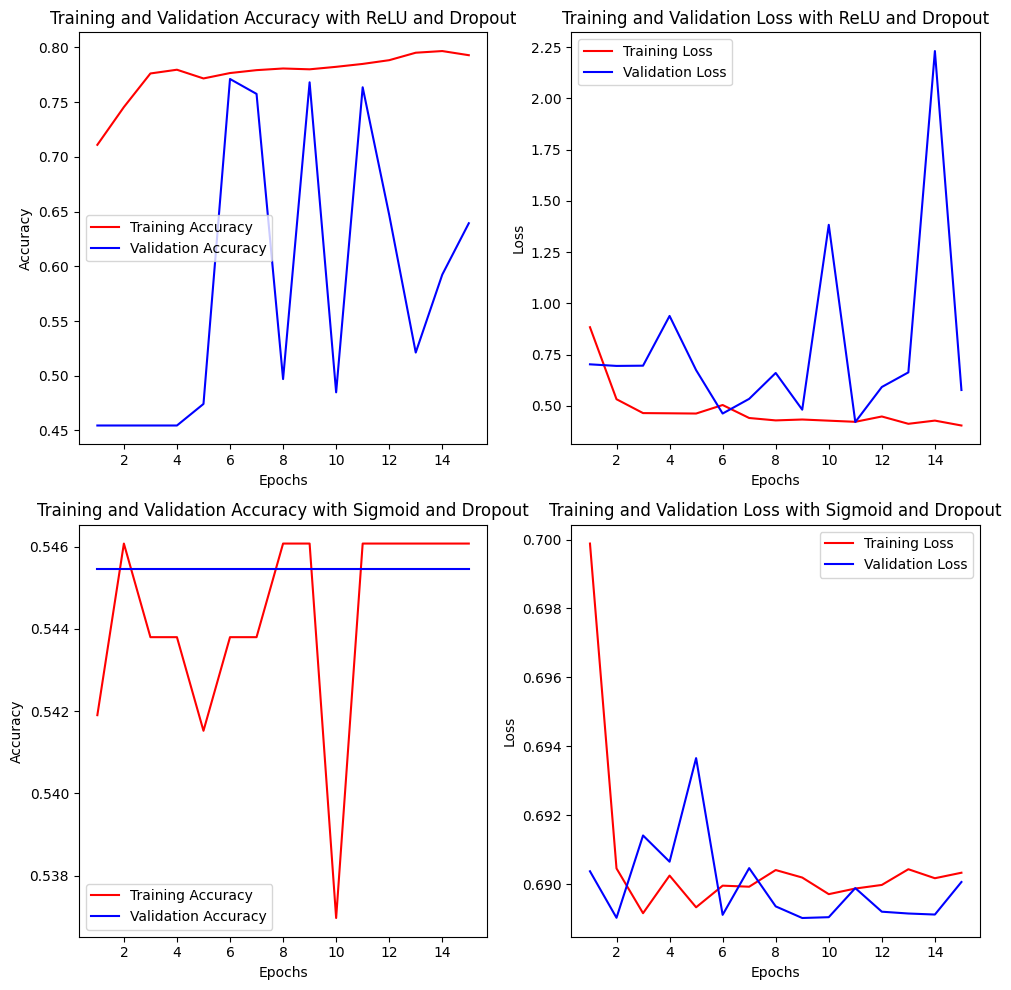

In [ ]:
# ReLU and Sigmoid with Dropout
performance_dict_of_ReLU_residualblock_dropout = history_of_residualblock_withdropout_ReLU.history
accuracy_values_ReLU_residualblock_dropout = performance_dict_of_ReLU_residualblock_dropout["accuracy"]
val_accuracy_values_ReLU_residualblock_dropout = performance_dict_of_ReLU_residualblock_dropout["val_accuracy"]
loss_values_ReLU_residualblock_dropout = performance_dict_of_ReLU_residualblock_dropout["loss"]
val_loss_values_ReLU_residualblock_dropout = performance_dict_of_ReLU_residualblock_dropout["val_loss"]
epochs = range(1, len(accuracy_values_ReLU_residualblock_dropout) + 1)

fig, axs = plt.subplots(2, 2, figsize=(10, 10))

axs[0, 0].plot(epochs, accuracy_values_ReLU_residualblock_dropout, "b", label="Training Accuracy", color = 'red')
axs[0, 0].plot(epochs, val_accuracy_values_ReLU_residualblock_dropout, "b", label="Validation Accuracy")
axs[0, 0].set_title("Training and Validation Accuracy with ReLU and Dropout")
axs[0, 0].set_xlabel("Epochs")
axs[0, 0].set_ylabel("Accuracy")
axs[0, 0].legend()

axs[0, 1].plot(epochs, loss_values_ReLU_residualblock_dropout, "b", label="Training Loss", color = 'red')
axs[0, 1].plot(epochs, val_loss_values_ReLU_residualblock_dropout, "b", label="Validation Loss")
axs[0, 1].set_title("Training and Validation Loss with ReLU and Dropout")
axs[0, 1].set_xlabel("Epochs")
axs[0, 1].set_ylabel("Loss")
axs[0, 1].legend()


# Plot for the second model
performance_dict_residualblock_withdropout_sigmoid = history_residualblock_withdropout_sigmoid.history
accuracy_values_performance_dict_residualblock_withdropout_sigmoid = performance_dict_residualblock_withdropout_sigmoid["accuracy"]
val_accuracy_values_performance_dict_residualblock_withdropout_sigmoid = performance_dict_residualblock_withdropout_sigmoid["val_accuracy"]
loss_values_performance_dict_residualblock_withdropout_sigmoid = performance_dict_residualblock_withdropout_sigmoid["loss"]
val_loss_values_performance_dict_residualblock_withdropout_sigmoid = performance_dict_residualblock_withdropout_sigmoid["val_loss"]
epochs = range(1, len(loss_values1) + 1)

axs[1, 0].plot(epochs, accuracy_values_performance_dict_residualblock_withdropout_sigmoid, "b", label="Training Accuracy", color = 'red')
axs[1, 0].plot(epochs, val_accuracy_values_performance_dict_residualblock_withdropout_sigmoid, "b", label="Validation Accuracy")
axs[1, 0].set_title("Training and Validation Accuracy with Sigmoid and Dropout")
axs[1, 0].set_xlabel("Epochs")
axs[1, 0].set_ylabel("Accuracy")
axs[1, 0].legend()

axs[1, 1].plot(epochs, loss_values_performance_dict_residualblock_withdropout_sigmoid, "b", label="Training Loss", color = 'red')
axs[1, 1].plot(epochs, val_loss_values_performance_dict_residualblock_withdropout_sigmoid, "b", label="Validation Loss")
axs[1, 1].set_title("Training and Validation Loss with Sigmoid and Dropout")
axs[1, 1].set_xlabel("Epochs")
axs[1, 1].set_ylabel("Loss")
axs[1, 1].legend()

plt.tight_layout()
plt.show()

<ipython-input-60-fd07f846d270>:11: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b" (-> color=(0.0, 0.0, 1.0, 1)). The keyword argument will take precedence.
  axs[0, 0].plot(epochs, accuracy_values_ReLU_residualblock, "b", label="Training Accuracy", color = 'red')
<ipython-input-60-fd07f846d270>:18: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b" (-> color=(0.0, 0.0, 1.0, 1)). The keyword argument will take precedence.
  axs[0, 1].plot(epochs, loss_values_ReLU_residualblock, "b", label="Training Loss", color = 'red')
<ipython-input-60-fd07f846d270>:34: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b" (-> color=(0.0, 0.0, 1.0, 1)). The keyword argument will take precedence.
  axs[1, 0].plot(epochs, accuracy_values_performance_dict_residualblock_sigmoid, "b", label="Training Accuracy", color = 'red')
<ipython-input-60-fd07f846d270>:41: UserWar

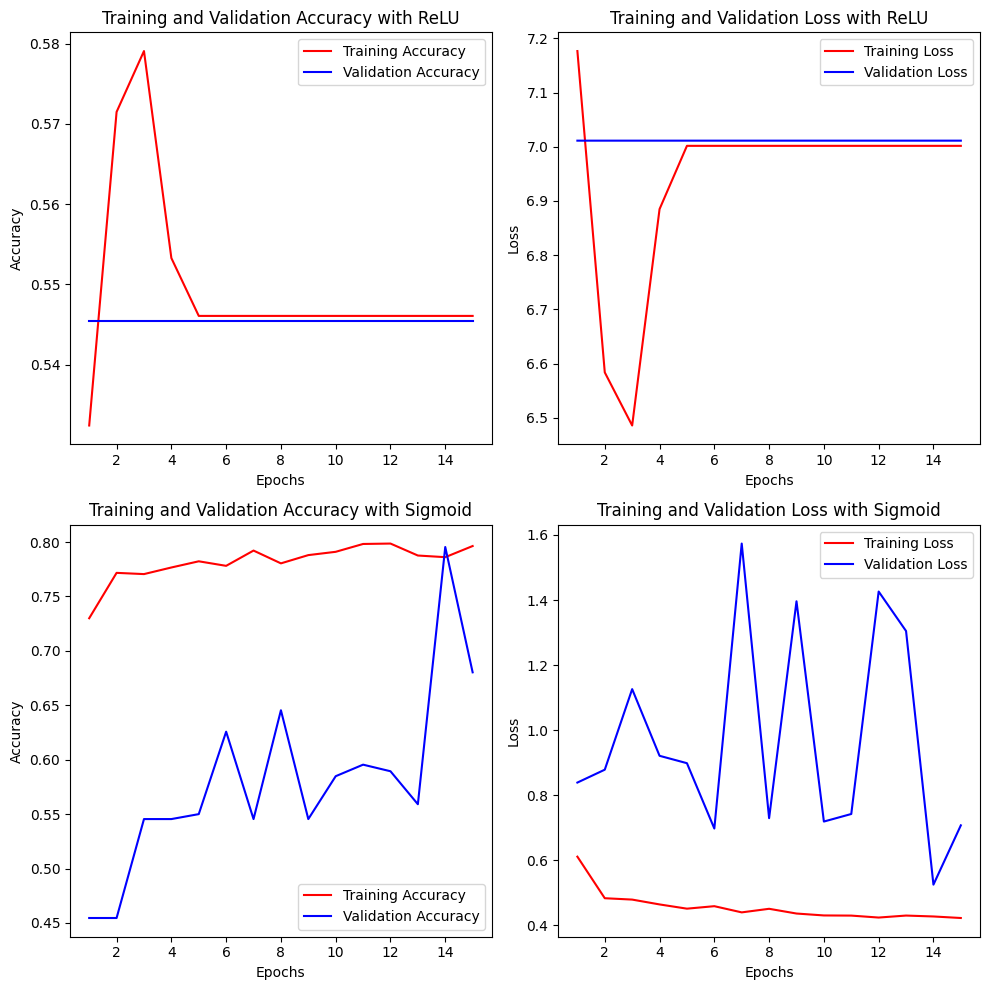

In [ ]:
# ReLU and Sigmoid without Dropout
performance_dict_of_ReLU_residualblock = history_residualblock_withoutdropout_ReLU.history
accuracy_values_ReLU_residualblock = performance_dict_of_ReLU_residualblock["accuracy"]
val_accuracy_values_ReLU_residualblock = performance_dict_of_ReLU_residualblock["val_accuracy"]
loss_values_ReLU_residualblock = performance_dict_of_ReLU_residualblock["loss"]
val_loss_values_ReLU_residualblock = performance_dict_of_ReLU_residualblock["val_loss"]
epochs = range(1, len(accuracy_values_ReLU_residualblock) + 1)

fig, axs = plt.subplots(2, 2, figsize=(10, 10))

axs[0, 0].plot(epochs, accuracy_values_ReLU_residualblock, "b", label="Training Accuracy", color = 'red')
axs[0, 0].plot(epochs, val_accuracy_values_ReLU_residualblock, "b", label="Validation Accuracy")
axs[0, 0].set_title("Training and Validation Accuracy with ReLU")
axs[0, 0].set_xlabel("Epochs")
axs[0, 0].set_ylabel("Accuracy")
axs[0, 0].legend()

axs[0, 1].plot(epochs, loss_values_ReLU_residualblock, "b", label="Training Loss", color = 'red')
axs[0, 1].plot(epochs, val_loss_values_ReLU_residualblock, "b", label="Validation Loss")
axs[0, 1].set_title("Training and Validation Loss with ReLU")
axs[0, 1].set_xlabel("Epochs")
axs[0, 1].set_ylabel("Loss")
axs[0, 1].legend()


# Plot for the second model
performance_dict_residualblock_sigmoid = history_residualblock_withoutdropout_sigmoid.history
accuracy_values_performance_dict_residualblock_sigmoid = performance_dict_residualblock_sigmoid["accuracy"]
val_accuracy_values_performance_dict_residualblock_sigmoid = performance_dict_residualblock_sigmoid["val_accuracy"]
loss_values_performance_dict_residualblock_sigmoid = performance_dict_residualblock_sigmoid["loss"]
val_loss_values_performance_dict_residualblock_sigmoid = performance_dict_residualblock_sigmoid["val_loss"]
epochs = range(1, len(loss_values1) + 1)

axs[1, 0].plot(epochs, accuracy_values_performance_dict_residualblock_sigmoid, "b", label="Training Accuracy", color = 'red')
axs[1, 0].plot(epochs, val_accuracy_values_performance_dict_residualblock_sigmoid, "b", label="Validation Accuracy")
axs[1, 0].set_title("Training and Validation Accuracy with Sigmoid")
axs[1, 0].set_xlabel("Epochs")
axs[1, 0].set_ylabel("Accuracy")
axs[1, 0].legend()

axs[1, 1].plot(epochs, loss_values_performance_dict_residualblock_sigmoid, "b", label="Training Loss", color = 'red')
axs[1, 1].plot(epochs, val_loss_values_performance_dict_residualblock_sigmoid, "b", label="Validation Loss")
axs[1, 1].set_title("Training and Validation Loss with Sigmoid")
axs[1, 1].set_xlabel("Epochs")
axs[1, 1].set_ylabel("Loss")
axs[1, 1].legend()

plt.tight_layout()
plt.show()

# Fine Tuning ReLU Models to Select Best Model 

In [ ]:
#ReLU

# Our input feature map is 150x150x3: 150x150 for the image pixels, and 3 for
# the three color channels: R, G, and B
img_input = layers.Input(shape=(150, 150, 3))

# First convolution extracts 16 filters that are 3x3
# Convolution is followed by max-pooling layer with a 2x2 window
x = layers.Conv2D(16, 3, activation='relu')(img_input)
x = layers.MaxPooling2D(2)(x)
x = layers.Dropout(0.05)(x)

# Second convolution extracts 32 filters that are 3x3
# Convolution is followed by max-pooling layer with a 2x2 window
x = layers.Conv2D(32, 3, activation='relu')(x)
x = layers.MaxPooling2D(2)(x)
x = layers.Dropout(0.1)(x)

# Third convolution extracts 64 filters that are 3x3
# Convolution is followed by max-pooling layer with a 2x2 window
x = layers.Convolution2D(64, 3, activation='relu')(x)
x = layers.MaxPooling2D(2)(x)
x = layers.Dropout(0.1)(x)


# Flatten feature map to a 1-dim tensor
x = layers.Flatten()(x)

# Create a fully connected layer with ReLU activation and 512 hidden units - added dropout
x = layers.Dense(512, activation='relu')(x)

# Add a dropout rate of 0.2
x = layers.Dropout(0.2)(x)

# Create output layer with a single node and sigmoid activation
output = layers.Dense(1, activation='sigmoid')(x)

# Configure and compile the model
model_self_selected_best = Model(img_input, output)
model_self_selected_best.compile(loss='binary_crossentropy',
              optimizer=RMSprop(lr=0.001),
              metrics=['accuracy'])

In [ ]:
model_self_selected_best.summary()

Model: "model_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_9 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 conv2d_44 (Conv2D)          (None, 148, 148, 16)      448       
                                                                 
 max_pooling2d_24 (MaxPoolin  (None, 74, 74, 16)       0         
 g2D)                                                            
                                                                 
 dropout_8 (Dropout)         (None, 74, 74, 16)        0         
                                                                 
 conv2d_45 (Conv2D)          (None, 72, 72, 32)        4640      
                                                                 
 max_pooling2d_25 (MaxPoolin  (None, 36, 36, 32)       0         
 g2D)                                                     

In [ ]:
history_self_selected_best_model = model_self_selected_best.fit(
      train_generator,
      steps_per_epoch=None,
      epochs=20,
      validation_data=validation_generator,
      validation_steps=None,
      verbose=2)

Epoch 1/20
132/132 - 148s - loss: 0.6006 - accuracy: 0.6936 - val_loss: 0.4888 - val_accuracy: 0.7712 - 148s/epoch - 1s/step
Epoch 2/20
132/132 - 107s - loss: 0.4925 - accuracy: 0.7539 - val_loss: 0.4342 - val_accuracy: 0.7955 - 107s/epoch - 814ms/step
Epoch 3/20
132/132 - 102s - loss: 0.4733 - accuracy: 0.7592 - val_loss: 0.4192 - val_accuracy: 0.7955 - 102s/epoch - 771ms/step
Epoch 4/20
132/132 - 102s - loss: 0.4507 - accuracy: 0.7778 - val_loss: 0.4113 - val_accuracy: 0.7909 - 102s/epoch - 771ms/step
Epoch 5/20
132/132 - 101s - loss: 0.4484 - accuracy: 0.7774 - val_loss: 0.4077 - val_accuracy: 0.7879 - 101s/epoch - 766ms/step
Epoch 6/20
132/132 - 101s - loss: 0.4311 - accuracy: 0.7948 - val_loss: 0.3826 - val_accuracy: 0.8030 - 101s/epoch - 763ms/step
Epoch 7/20
132/132 - 96s - loss: 0.4296 - accuracy: 0.7941 - val_loss: 0.4036 - val_accuracy: 0.7955 - 96s/epoch - 728ms/step
Epoch 8/20
132/132 - 97s - loss: 0.4278 - accuracy: 0.7922 - val_loss: 0.3890 - val_accuracy: 0.8076 - 97s/ep

<ipython-input-63-f233e3ce1278>:5: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b" (-> color=(0.0, 0.0, 1.0, 1)). The keyword argument will take precedence.
  plt.plot(epochs, accuracy_values, "b", label="Training Accuracy", color = 'red')


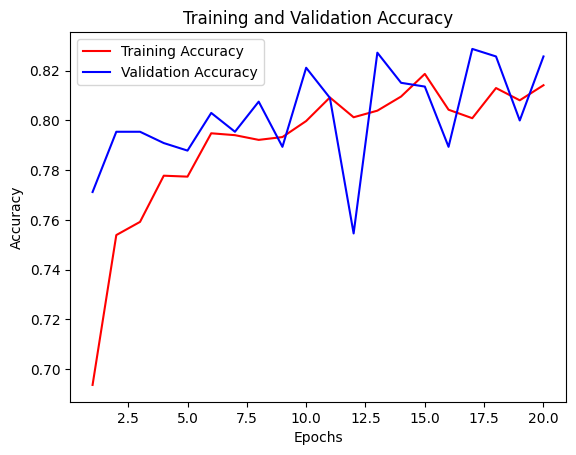

In [ ]:
performance_dict_self_selected_best_model = history_self_selected_best_model.history
accuracy_values = performance_dict_self_selected_best_model["accuracy"]
val_accuracy_values = performance_dict_self_selected_best_model["val_accuracy"]
epochs = range(1, len(accuracy_values) + 1)
plt.plot(epochs, accuracy_values, "b", label="Training Accuracy", color = 'red')
plt.plot(epochs, val_accuracy_values, "b", label="Validation Accuracy")
plt.title("Training and Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

<ipython-input-65-f95944d2302b>:5: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b" (-> color=(0.0, 0.0, 1.0, 1)). The keyword argument will take precedence.
  plt.plot(epochs, loss_values, "b", label="Training Loss", color = 'red')


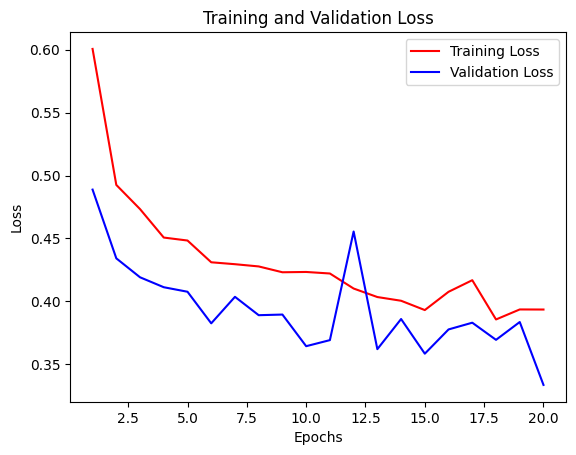

In [ ]:
performance_dict_self_selected_best_model = history_self_selected_best_model.history
loss_values = performance_dict_self_selected_best_model["loss"]
val_loss_values = performance_dict_self_selected_best_model["val_loss"]
epochs = range(1, len(loss_values) + 1)
plt.plot(epochs, loss_values, "b", label="Training Loss", color = 'red')
plt.plot(epochs, val_loss_values, "b", label="Validation Loss")
plt.title("Training and Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

<ipython-input-74-ec2623485220>:10: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b" (-> color=(0.0, 0.0, 1.0, 1)). The keyword argument will take precedence.
  axs[0].plot(epochs, accuracy_values, "b", label="Training Accuracy", color='red')
<ipython-input-74-ec2623485220>:17: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b" (-> color=(0.0, 0.0, 1.0, 1)). The keyword argument will take precedence.
  axs[1].plot(epochs, loss_values, "b", label="Training Loss", color='red')


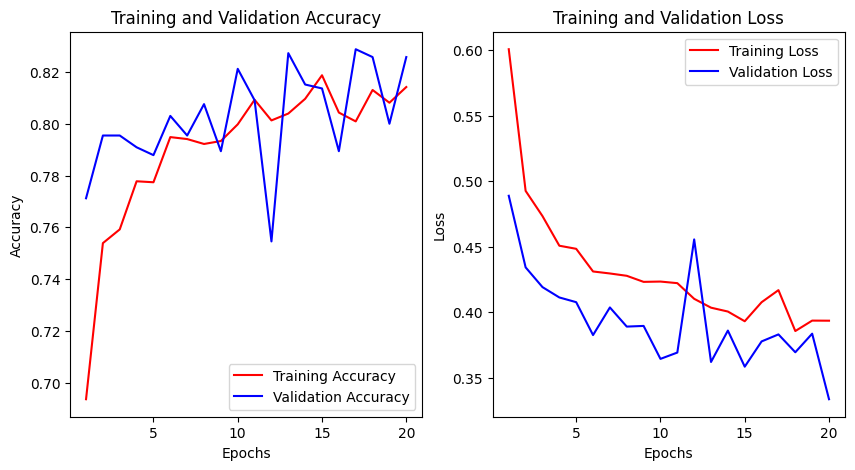

In [ ]:
performance_dict_self_selected_best_model = history_self_selected_best_model.history
accuracy_values = performance_dict_self_selected_best_model["accuracy"]
val_accuracy_values = performance_dict_self_selected_best_model["val_accuracy"]
loss_values = performance_dict_self_selected_best_model["loss"]
val_loss_values = performance_dict_self_selected_best_model["val_loss"]
epochs = range(1, len(accuracy_values) + 1)

fig, axs = plt.subplots(1, 2, figsize=(10, 5))

axs[0].plot(epochs, accuracy_values, "b", label="Training Accuracy", color='red')
axs[0].plot(epochs, val_accuracy_values, "b", label="Validation Accuracy")
axs[0].set_title("Training and Validation Accuracy")
axs[0].set_xlabel("Epochs")
axs[0].set_ylabel("Accuracy")
axs[0].legend()

axs[1].plot(epochs, loss_values, "b", label="Training Loss", color='red')
axs[1].plot(epochs, val_loss_values, "b", label="Validation Loss")
axs[1].set_title("Training and Validation Loss")
axs[1].set_xlabel("Epochs")
axs[1].set_ylabel("Loss")
axs[1].legend()

plt.show()

In [ ]:
# trial 2 
#ReLU

# Our input feature map is 150x150x3: 150x150 for the image pixels, and 3 for
# the three color channels: R, G, and B
img_input = layers.Input(shape=(150, 150, 3))

# First convolution extracts 16 filters that are 3x3
# Convolution is followed by max-pooling layer with a 2x2 window
x = layers.Conv2D(16, 3, activation='relu')(img_input)
x = layers.MaxPooling2D(2)(x)
x = layers.Dropout(0.05)(x)

# Second convolution extracts 32 filters that are 3x3
# Convolution is followed by max-pooling layer with a 2x2 window
x = layers.Conv2D(32, 3, activation='relu')(x)
x = layers.MaxPooling2D(2)(x)
x = layers.Dropout(0.1)(x)

# Third convolution extracts 64 filters that are 3x3
# Convolution is followed by max-pooling layer with a 2x2 window
x = layers.Convolution2D(64, 3, activation='relu')(x)
x = layers.MaxPooling2D(2)(x)
x = layers.Dropout(0.1)(x)


# Flatten feature map to a 1-dim tensor
x = layers.Flatten()(x)

# Create a fully connected layer with ReLU activation and 512 hidden units - added dropout
x = layers.Dense(512, activation='relu')(x)

# Add a dropout rate of 0.1
x = layers.Dropout(0.1)(x)

# Create output layer with a single node and sigmoid activation
output = layers.Dense(1, activation='sigmoid')(x)

# Configure and compile the model
model_self_selected_best2 = Model(img_input, output)
model_self_selected_best2.compile(loss='binary_crossentropy',
              optimizer=RMSprop(lr=0.001),
              metrics=['accuracy'])

In [ ]:
model_self_selected_best2.summary()

Model: "model_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_11 (InputLayer)       [(None, 150, 150, 3)]     0         
                                                                 
 conv2d_50 (Conv2D)          (None, 148, 148, 16)      448       
                                                                 
 max_pooling2d_30 (MaxPoolin  (None, 74, 74, 16)       0         
 g2D)                                                            
                                                                 
 dropout_16 (Dropout)        (None, 74, 74, 16)        0         
                                                                 
 conv2d_51 (Conv2D)          (None, 72, 72, 32)        4640      
                                                                 
 max_pooling2d_31 (MaxPoolin  (None, 36, 36, 32)       0         
 g2D)                                                     

In [ ]:
history_self_selected_best_model = model_self_selected_best2.fit(
      train_generator,
      steps_per_epoch=None,
      epochs=20,
      validation_data=validation_generator,
      validation_steps=None,
      verbose=2)

Epoch 1/20
132/132 - 131s - loss: 0.7333 - accuracy: 0.6337 - val_loss: 0.5779 - val_accuracy: 0.7561 - 131s/epoch - 989ms/step
Epoch 2/20
132/132 - 109s - loss: 0.5376 - accuracy: 0.7364 - val_loss: 0.4390 - val_accuracy: 0.7712 - 109s/epoch - 825ms/step
Epoch 3/20
132/132 - 102s - loss: 0.4938 - accuracy: 0.7615 - val_loss: 0.4081 - val_accuracy: 0.7879 - 102s/epoch - 771ms/step
Epoch 4/20
132/132 - 101s - loss: 0.4578 - accuracy: 0.7736 - val_loss: 0.4025 - val_accuracy: 0.8045 - 101s/epoch - 766ms/step
Epoch 5/20
132/132 - 101s - loss: 0.4477 - accuracy: 0.7766 - val_loss: 0.4254 - val_accuracy: 0.7727 - 101s/epoch - 768ms/step
Epoch 6/20
132/132 - 109s - loss: 0.4352 - accuracy: 0.7850 - val_loss: 0.4276 - val_accuracy: 0.7788 - 109s/epoch - 823ms/step
Epoch 7/20
132/132 - 108s - loss: 0.4288 - accuracy: 0.7819 - val_loss: 0.4368 - val_accuracy: 0.7924 - 108s/epoch - 818ms/step
Epoch 8/20
132/132 - 101s - loss: 0.4227 - accuracy: 0.7994 - val_loss: 0.3811 - val_accuracy: 0.8182 - 

<ipython-input-81-8c5586dcec64>:10: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b" (-> color=(0.0, 0.0, 1.0, 1)). The keyword argument will take precedence.
  axs[0].plot(epochs, accuracy_values, "b", label="Training Accuracy", color='red')
<ipython-input-81-8c5586dcec64>:17: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b" (-> color=(0.0, 0.0, 1.0, 1)). The keyword argument will take precedence.
  axs[1].plot(epochs, loss_values, "b", label="Training Loss", color='red')


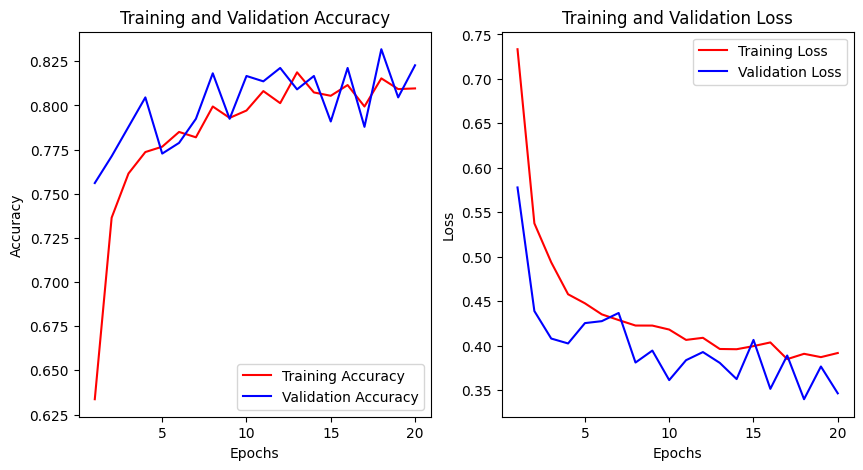

In [ ]:
performance_dict_self_selected_best_model = history_self_selected_best_model.history
accuracy_values = performance_dict_self_selected_best_model["accuracy"]
val_accuracy_values = performance_dict_self_selected_best_model["val_accuracy"]
loss_values = performance_dict_self_selected_best_model["loss"]
val_loss_values = performance_dict_self_selected_best_model["val_loss"]
epochs = range(1, len(accuracy_values) + 1)

fig, axs = plt.subplots(1, 2, figsize=(10, 5))

axs[0].plot(epochs, accuracy_values, "b", label="Training Accuracy", color='red')
axs[0].plot(epochs, val_accuracy_values, "b", label="Validation Accuracy")
axs[0].set_title("Training and Validation Accuracy")
axs[0].set_xlabel("Epochs")
axs[0].set_ylabel("Accuracy")
axs[0].legend()

axs[1].plot(epochs, loss_values, "b", label="Training Loss", color='red')
axs[1].plot(epochs, val_loss_values, "b", label="Validation Loss")
axs[1].set_title("Training and Validation Loss")
axs[1].set_xlabel("Epochs")
axs[1].set_ylabel("Loss")
axs[1].legend()

plt.show()

In [ ]:
# Adding rescale, rotation_range, width_shift_range, height_shift_range,
# shear_range, zoom_range, and horizontal flip to our ImageDataGenerator
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,)

# Note that the validation data should not be augmented!
val_datagen = ImageDataGenerator(rescale=1./255)

# Flow training images in batches of 32 using train_datagen generator
train_generator = train_datagen.flow_from_directory(
        train_dir,  # This is the source directory for training images
        target_size=(150, 150),  # All images will be resized to 150x150
        batch_size=20,
        # Since we use binary_crossentropy loss, we need binary labels
        class_mode='binary')

# Flow validation images in batches of 32 using val_datagen generator
validation_generator = val_datagen.flow_from_directory(
        validation_dir,
        target_size=(150, 150),
        batch_size=20,
        class_mode='binary')

Found 2637 images belonging to 2 classes.
Found 660 images belonging to 2 classes.


In [ ]:
# ReLU with Dropout of 0.1

inputs = tf.keras.Input(shape=(150, 150, 3))
x = tf.keras.layers.Rescaling(1/255)(inputs) # we rescale data             
def residual_block(x, filters, pooling=False):
    residual = x
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Conv2D(filters, 3, activation="relu", padding="same")(x) 
    
    if pooling:
       x = tf.keras.layers.MaxPooling2D(2, padding="same")(x)
       residual = tf.keras.layers.Conv2D(filters, 1, strides=2)(residual)
    elif filters != residual.shape[-1]:
       residual = tf.keras.layers.Conv2D(filters, 1)(residual)
       
    x = tf.keras.layers.add([x, residual]) 
       
    return x


x= residual_block(x, filters=64, pooling=True)
x = tf.keras.layers.Dropout(.1)(x)

x= residual_block(x, filters=64, pooling=True)
x = tf.keras.layers.Dropout(.1)(x)

x =residual_block(x, filters=64, pooling=True)
x = tf.keras.layers.Dropout(.1)(x)


x =residual_block(x, filters=16, pooling=False)

x = tf.keras.layers.Flatten()(x)  
x = tf.keras.layers.Dense(60, activation="relu")(x)

outputs = tf.keras.layers.Dense(1, activation="sigmoid")(x)

model_Residual_Block_with_dropout_ReLU = tf.keras.Model(inputs=inputs, outputs=outputs)
model_Residual_Block_with_dropout_ReLU.summary()

  # compile model
model_Residual_Block_with_dropout_ReLU.compile(loss= 'binary_crossentropy', optimizer=RMSprop(learning_rate=0.001), metrics=['accuracy'])

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 150, 150, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling_1 (Rescaling)        (None, 150, 150, 3)  0           ['input_2[0][0]']                
                                                                                                  
 batch_normalization_4 (BatchNo  (None, 150, 150, 3)  12         ['rescaling_1[0][0]']            
 rmalization)                                                                                     
                                                                                            

In [ ]:
history_of_residualblock_withdropout_ReLU2 = model_Residual_Block_with_dropout_ReLU.fit(
      train_generator,
      steps_per_epoch=None,
      epochs=25,
      validation_data=validation_generator,
      validation_steps=None,
      verbose=2)

Epoch 1/25
132/132 - 276s - loss: 0.7553 - accuracy: 0.7160 - val_loss: 0.7018 - val_accuracy: 0.4545 - 276s/epoch - 2s/step
Epoch 2/25
132/132 - 262s - loss: 0.5085 - accuracy: 0.7592 - val_loss: 0.6894 - val_accuracy: 0.5455 - 262s/epoch - 2s/step
Epoch 3/25
132/132 - 261s - loss: 0.4636 - accuracy: 0.7539 - val_loss: 0.7303 - val_accuracy: 0.4545 - 261s/epoch - 2s/step
Epoch 4/25
132/132 - 260s - loss: 0.4532 - accuracy: 0.7763 - val_loss: 0.7027 - val_accuracy: 0.4545 - 260s/epoch - 2s/step
Epoch 5/25
132/132 - 260s - loss: 0.4546 - accuracy: 0.7804 - val_loss: 6.4930 - val_accuracy: 0.5485 - 260s/epoch - 2s/step
Epoch 6/25
132/132 - 267s - loss: 0.4438 - accuracy: 0.7888 - val_loss: 0.4897 - val_accuracy: 0.7455 - 267s/epoch - 2s/step
Epoch 7/25
132/132 - 261s - loss: 0.4377 - accuracy: 0.7706 - val_loss: 0.5258 - val_accuracy: 0.7318 - 261s/epoch - 2s/step
Epoch 8/25
132/132 - 261s - loss: 0.4352 - accuracy: 0.7888 - val_loss: 0.6018 - val_accuracy: 0.7773 - 261s/epoch - 2s/step


<ipython-input-16-4c3bfd25c679>:10: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b" (-> color=(0.0, 0.0, 1.0, 1)). The keyword argument will take precedence.
  axs[0].plot(epochs, accuracy_values, "b", label="Training Accuracy", color='red')
<ipython-input-16-4c3bfd25c679>:17: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b" (-> color=(0.0, 0.0, 1.0, 1)). The keyword argument will take precedence.
  axs[1].plot(epochs, loss_values, "b", label="Training Loss", color='red')


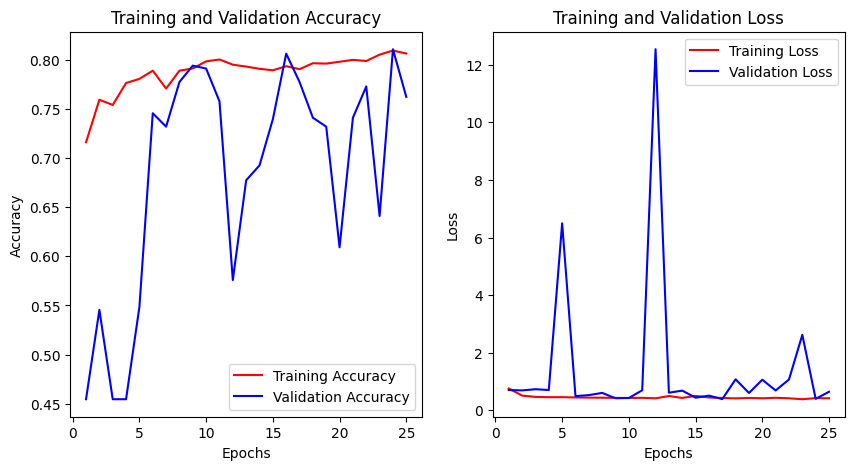

In [ ]:
performance_dict_self_selected_best_model = history_of_residualblock_withdropout_ReLU2.history
accuracy_values = performance_dict_self_selected_best_model["accuracy"]
val_accuracy_values = performance_dict_self_selected_best_model["val_accuracy"]
loss_values = performance_dict_self_selected_best_model["loss"]
val_loss_values = performance_dict_self_selected_best_model["val_loss"]
epochs = range(1, len(accuracy_values) + 1)

fig, axs = plt.subplots(1, 2, figsize=(10, 5))

axs[0].plot(epochs, accuracy_values, "b", label="Training Accuracy", color='red')
axs[0].plot(epochs, val_accuracy_values, "b", label="Validation Accuracy")
axs[0].set_title("Training and Validation Accuracy")
axs[0].set_xlabel("Epochs")
axs[0].set_ylabel("Accuracy")
axs[0].legend()

axs[1].plot(epochs, loss_values, "b", label="Training Loss", color='red')
axs[1].plot(epochs, val_loss_values, "b", label="Validation Loss")
axs[1].set_title("Training and Validation Loss")
axs[1].set_xlabel("Epochs")
axs[1].set_ylabel("Loss")
axs[1].legend()

plt.show()

In [ ]:
# All images will be rescaled by 1./255
train_datagen = ImageDataGenerator(rescale=1./255)
val_datagen = ImageDataGenerator(rescale=1./255)

# Flow training images in batches of 20 using train_datagen generator
train_generator = train_datagen.flow_from_directory(
        train_dir,  # This is the source directory for training images
        target_size=(150, 150),  # All images will be resized to 150x150
        batch_size=20,
        # Since we use binary_crossentropy loss, we need binary labels
        class_mode='binary')

# Flow validation images in batches of 20 using val_datagen generator
validation_generator = val_datagen.flow_from_directory(
        validation_dir,
        target_size=(150, 150),
        batch_size=20,
        class_mode='binary')

Found 2637 images belonging to 2 classes.
Found 660 images belonging to 2 classes.


In [ ]:
# ReLU with Dropout of 0.1

inputs = tf.keras.Input(shape=(150, 150, 3))
x = tf.keras.layers.Rescaling(1/255)(inputs) # we rescale data             
def residual_block(x, filters, pooling=False):
    residual = x
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Conv2D(filters, 3, activation="relu", padding="same")(x) 
    
    if pooling:
       x = tf.keras.layers.MaxPooling2D(2, padding="same")(x)
       residual = tf.keras.layers.Conv2D(filters, 1, strides=2)(residual)
    elif filters != residual.shape[-1]:
       residual = tf.keras.layers.Conv2D(filters, 1)(residual)
       
    x = tf.keras.layers.add([x, residual]) 
       
    return x


x= residual_block(x, filters=64, pooling=True)
x = tf.keras.layers.Dropout(.1)(x)

x= residual_block(x, filters=64, pooling=True)
x = tf.keras.layers.Dropout(.1)(x)

x =residual_block(x, filters=64, pooling=True)
x = tf.keras.layers.Dropout(.1)(x)


x =residual_block(x, filters=16, pooling=False)

x = tf.keras.layers.Flatten()(x)  
x = tf.keras.layers.Dense(60, activation="relu")(x)

outputs = tf.keras.layers.Dense(1, activation="sigmoid")(x)

model_Residual_Block_with_dropout_ReLU = tf.keras.Model(inputs=inputs, outputs=outputs)
model_Residual_Block_with_dropout_ReLU.summary()

  # compile model
model_Residual_Block_with_dropout_ReLU.compile(loss= 'binary_crossentropy', optimizer=RMSprop(learning_rate=0.001), metrics=['accuracy'])

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 150, 150, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling (Rescaling)          (None, 150, 150, 3)  0           ['input_1[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 150, 150, 3)  12         ['rescaling[0][0]']              
 alization)                                                                                       
                                                                                              

In [ ]:
history_of_residualblock_withdropout_ReLU = model_Residual_Block_with_dropout_ReLU.fit(
      train_generator,
      steps_per_epoch=None,
      epochs=20,
      validation_data=validation_generator,
      validation_steps=None,
      verbose=2)

Epoch 1/20
132/132 - 253s - loss: 0.8733 - accuracy: 0.7330 - val_loss: 0.6896 - val_accuracy: 0.5455 - 253s/epoch - 2s/step
Epoch 2/20
132/132 - 249s - loss: 0.4955 - accuracy: 0.7801 - val_loss: 0.9971 - val_accuracy: 0.4545 - 249s/epoch - 2s/step
Epoch 3/20
132/132 - 253s - loss: 0.4479 - accuracy: 0.7816 - val_loss: 0.6580 - val_accuracy: 0.5455 - 253s/epoch - 2s/step
Epoch 4/20
132/132 - 249s - loss: 0.4145 - accuracy: 0.7918 - val_loss: 0.7666 - val_accuracy: 0.5652 - 249s/epoch - 2s/step
Epoch 5/20
132/132 - 249s - loss: 0.4135 - accuracy: 0.7899 - val_loss: 1.5696 - val_accuracy: 0.6333 - 249s/epoch - 2s/step
Epoch 6/20
132/132 - 247s - loss: 0.4179 - accuracy: 0.7990 - val_loss: 0.4477 - val_accuracy: 0.7667 - 247s/epoch - 2s/step
Epoch 7/20
132/132 - 254s - loss: 0.4009 - accuracy: 0.7960 - val_loss: 0.3511 - val_accuracy: 0.8045 - 254s/epoch - 2s/step
Epoch 8/20
132/132 - 249s - loss: 0.3694 - accuracy: 0.8058 - val_loss: 0.3861 - val_accuracy: 0.7939 - 249s/epoch - 2s/step


<ipython-input-11-3da76cfaa771>:10: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b" (-> color=(0.0, 0.0, 1.0, 1)). The keyword argument will take precedence.
  axs[0].plot(epochs, accuracy_values, "b", label="Training Accuracy", color='red')
<ipython-input-11-3da76cfaa771>:17: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b" (-> color=(0.0, 0.0, 1.0, 1)). The keyword argument will take precedence.
  axs[1].plot(epochs, loss_values, "b", label="Training Loss", color='red')


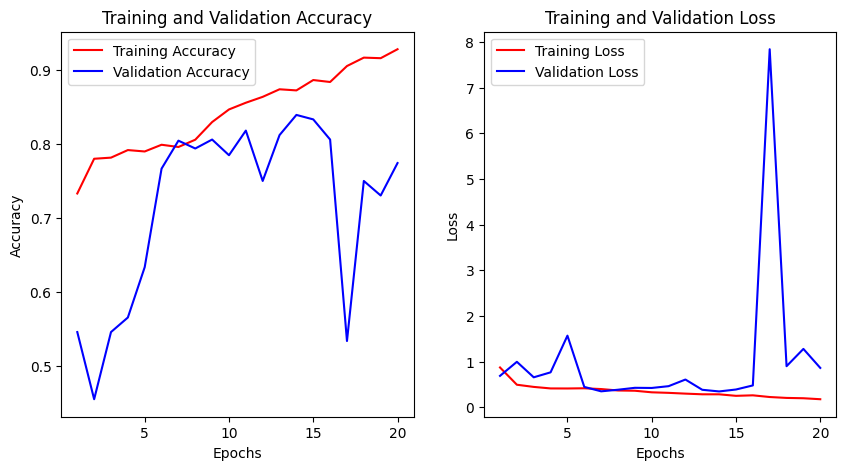

In [ ]:
performance_dict_self_selected_best_model = history_of_residualblock_withdropout_ReLU.history
accuracy_values = performance_dict_self_selected_best_model["accuracy"]
val_accuracy_values = performance_dict_self_selected_best_model["val_accuracy"]
loss_values = performance_dict_self_selected_best_model["loss"]
val_loss_values = performance_dict_self_selected_best_model["val_loss"]
epochs = range(1, len(accuracy_values) + 1)

fig, axs = plt.subplots(1, 2, figsize=(10, 5))

axs[0].plot(epochs, accuracy_values, "b", label="Training Accuracy", color='red')
axs[0].plot(epochs, val_accuracy_values, "b", label="Validation Accuracy")
axs[0].set_title("Training and Validation Accuracy")
axs[0].set_xlabel("Epochs")
axs[0].set_ylabel("Accuracy")
axs[0].legend()

axs[1].plot(epochs, loss_values, "b", label="Training Loss", color='red')
axs[1].plot(epochs, val_loss_values, "b", label="Validation Loss")
axs[1].set_title("Training and Validation Loss")
axs[1].set_xlabel("Epochs")
axs[1].set_ylabel("Loss")
axs[1].legend()

plt.show()

# Fine Tuning Models Further with More Epochs

In [ ]:
# All images will be rescaled by 1./255
train_datagen = ImageDataGenerator(rescale=1./255)
val_datagen = ImageDataGenerator(rescale=1./255)

# Flow training images in batches of 20 using train_datagen generator
train_generator = train_datagen.flow_from_directory(
        train_dir,  # This is the source directory for training images
        target_size=(150, 150),  # All images will be resized to 150x150
        batch_size=20,
        # Since we use binary_crossentropy loss, we need binary labels
        class_mode='binary')

# Flow validation images in batches of 20 using val_datagen generator
validation_generator = val_datagen.flow_from_directory(
        validation_dir,
        target_size=(150, 150),
        batch_size=20,
        class_mode='binary')

Found 2637 images belonging to 2 classes.
Found 660 images belonging to 2 classes.


In [ ]:
#ReLU

# Our input feature map is 150x150x3: 150x150 for the image pixels, and 3 for
# the three color channels: R, G, and B
img_input = layers.Input(shape=(150, 150, 3))

# First convolution extracts 16 filters that are 3x3
# Convolution is followed by max-pooling layer with a 2x2 window
x = layers.Conv2D(16, 3, activation='relu')(img_input)
x = layers.MaxPooling2D(2)(x)
x = layers.Dropout(0.05)(x)

# Second convolution extracts 32 filters that are 3x3
# Convolution is followed by max-pooling layer with a 2x2 window
x = layers.Conv2D(32, 3, activation='relu')(x)
x = layers.MaxPooling2D(2)(x)
x = layers.Dropout(0.1)(x)

# Third convolution extracts 64 filters that are 3x3
# Convolution is followed by max-pooling layer with a 2x2 window
x = layers.Convolution2D(64, 3, activation='relu')(x)
x = layers.MaxPooling2D(2)(x)
x = layers.Dropout(0.1)(x)


# Flatten feature map to a 1-dim tensor
x = layers.Flatten()(x)

# Create a fully connected layer with ReLU activation and 512 hidden units - added dropout
x = layers.Dense(512, activation='relu')(x)

# Add a dropout rate of 0.1
x = layers.Dropout(0.1)(x)

# Create output layer with a single node and sigmoid activation
output = layers.Dense(1, activation='sigmoid')(x)

# Configure and compile the model
model_self_selected_best2 = Model(img_input, output)
model_self_selected_best2.compile(loss='binary_crossentropy',
              optimizer=RMSprop(lr=0.001),
              metrics=['accuracy'])

In [ ]:
history_self_selected_best_model = model_self_selected_best2.fit(
      train_generator,
      steps_per_epoch=None,
      epochs=40,
      validation_data=validation_generator,
      validation_steps=None,
      verbose=2)

Epoch 1/40
132/132 - 95s - loss: 0.7163 - accuracy: 0.6303 - val_loss: 0.5536 - val_accuracy: 0.6864 - 95s/epoch - 720ms/step
Epoch 2/40
132/132 - 97s - loss: 0.5177 - accuracy: 0.7414 - val_loss: 0.4357 - val_accuracy: 0.7742 - 97s/epoch - 731ms/step
Epoch 3/40
132/132 - 97s - loss: 0.4748 - accuracy: 0.7706 - val_loss: 0.4299 - val_accuracy: 0.8197 - 97s/epoch - 737ms/step
Epoch 4/40
132/132 - 98s - loss: 0.4538 - accuracy: 0.7861 - val_loss: 0.4235 - val_accuracy: 0.7697 - 98s/epoch - 742ms/step
Epoch 5/40
132/132 - 98s - loss: 0.4302 - accuracy: 0.7876 - val_loss: 0.3887 - val_accuracy: 0.8182 - 98s/epoch - 746ms/step
Epoch 6/40
132/132 - 100s - loss: 0.4092 - accuracy: 0.8077 - val_loss: 0.4178 - val_accuracy: 0.8015 - 100s/epoch - 757ms/step
Epoch 7/40
132/132 - 94s - loss: 0.3867 - accuracy: 0.8093 - val_loss: 0.3591 - val_accuracy: 0.8288 - 94s/epoch - 714ms/step
Epoch 8/40
132/132 - 98s - loss: 0.3852 - accuracy: 0.8149 - val_loss: 0.3758 - val_accuracy: 0.7909 - 98s/epoch - 7

<ipython-input-10-8c5586dcec64>:10: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b" (-> color=(0.0, 0.0, 1.0, 1)). The keyword argument will take precedence.
  axs[0].plot(epochs, accuracy_values, "b", label="Training Accuracy", color='red')
<ipython-input-10-8c5586dcec64>:17: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b" (-> color=(0.0, 0.0, 1.0, 1)). The keyword argument will take precedence.
  axs[1].plot(epochs, loss_values, "b", label="Training Loss", color='red')


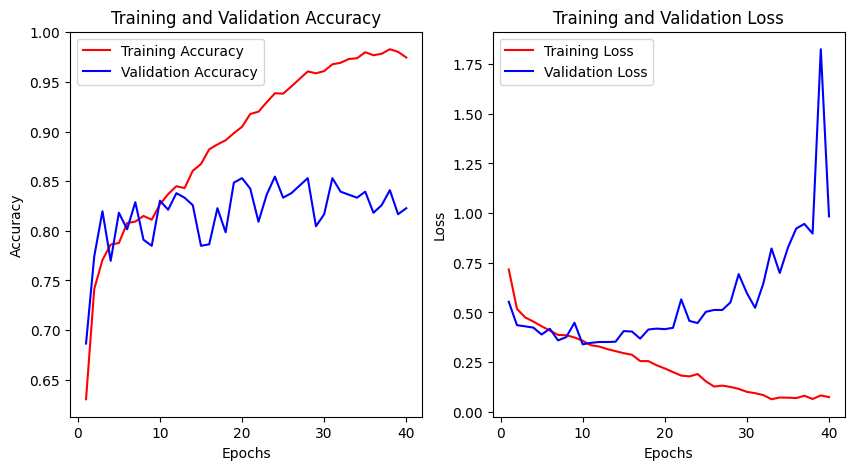

In [ ]:
performance_dict_self_selected_best_model = history_self_selected_best_model.history
accuracy_values = performance_dict_self_selected_best_model["accuracy"]
val_accuracy_values = performance_dict_self_selected_best_model["val_accuracy"]
loss_values = performance_dict_self_selected_best_model["loss"]
val_loss_values = performance_dict_self_selected_best_model["val_loss"]
epochs = range(1, len(accuracy_values) + 1)

fig, axs = plt.subplots(1, 2, figsize=(10, 5))

axs[0].plot(epochs, accuracy_values, "b", label="Training Accuracy", color='red')
axs[0].plot(epochs, val_accuracy_values, "b", label="Validation Accuracy")
axs[0].set_title("Training and Validation Accuracy")
axs[0].set_xlabel("Epochs")
axs[0].set_ylabel("Accuracy")
axs[0].legend()

axs[1].plot(epochs, loss_values, "b", label="Training Loss", color='red')
axs[1].plot(epochs, val_loss_values, "b", label="Validation Loss")
axs[1].set_title("Training and Validation Loss")
axs[1].set_xlabel("Epochs")
axs[1].set_ylabel("Loss")
axs[1].legend()

plt.show()

Very good model with high training accuracy, however, validation accuracy is 10% lower. Still might be overfitting data as we are using the original training images, not the augmented ones. Let's repeat this but use augmented training data! 

# Final Model

In [7]:
# Adding rescale, rotation_range, width_shift_range, height_shift_range,
# shear_range, zoom_range, and horizontal flip to our ImageDataGenerator
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,)

# Note that the validation data should not be augmented!
val_datagen = ImageDataGenerator(rescale=1./255)

# Flow training images in batches of 32 using train_datagen generator
train_generator = train_datagen.flow_from_directory(
        train_dir,  # This is the source directory for training images
        target_size=(150, 150),  # All images will be resized to 150x150
        batch_size=20,
        # Since we use binary_crossentropy loss, we need binary labels
        class_mode='binary')

# Flow validation images in batches of 32 using val_datagen generator
validation_generator = val_datagen.flow_from_directory(
        validation_dir,
        target_size=(150, 150),
        batch_size=20,
        class_mode='binary')

Found 2637 images belonging to 2 classes.
Found 660 images belonging to 2 classes.


In [8]:
#ReLU

# Our input feature map is 150x150x3: 150x150 for the image pixels, and 3 for
# the three color channels: R, G, and B
img_input = layers.Input(shape=(150, 150, 3))

# First convolution extracts 16 filters that are 3x3
# Convolution is followed by max-pooling layer with a 2x2 window
x = layers.Conv2D(16, 3, activation='relu')(img_input)
x = layers.MaxPooling2D(2)(x)
x = layers.Dropout(0.05)(x)

# Second convolution extracts 32 filters that are 3x3
# Convolution is followed by max-pooling layer with a 2x2 window
x = layers.Conv2D(32, 3, activation='relu')(x)
x = layers.MaxPooling2D(2)(x)
x = layers.Dropout(0.1)(x)

# Third convolution extracts 64 filters that are 3x3
# Convolution is followed by max-pooling layer with a 2x2 window
x = layers.Convolution2D(64, 3, activation='relu')(x)
x = layers.MaxPooling2D(2)(x)
x = layers.Dropout(0.1)(x)


# Flatten feature map to a 1-dim tensor
x = layers.Flatten()(x)

# Create a fully connected layer with ReLU activation and 512 hidden units - added dropout
x = layers.Dense(512, activation='relu')(x)

# Add a dropout rate of 0.1
x = layers.Dropout(0.1)(x)

# Create output layer with a single node and sigmoid activation
output = layers.Dense(1, activation='sigmoid')(x)

# Configure and compile the model
model_self_selected_best23 = Model(img_input, output)
model_self_selected_best23.compile(loss='binary_crossentropy',
              optimizer=RMSprop(lr=0.001),
              metrics=['accuracy'])

In [9]:
model_self_selected_best23.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 148, 148, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 74, 74, 16)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 74, 74, 16)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 72, 72, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 36, 36, 32)       0         
 2D)                                                         

In [10]:
history_self_selected_best_model23 = model_self_selected_best23.fit(
      train_generator,
      steps_per_epoch=None,
      epochs=100,
      validation_data=validation_generator,
      validation_steps=None,
      verbose=2)

Epoch 1/100
132/132 - 117s - loss: 0.6959 - accuracy: 0.6022 - val_loss: 0.6034 - val_accuracy: 0.7636 - 117s/epoch - 889ms/step
Epoch 2/100
132/132 - 112s - loss: 0.5571 - accuracy: 0.7228 - val_loss: 0.6693 - val_accuracy: 0.5985 - 112s/epoch - 847ms/step
Epoch 3/100
132/132 - 110s - loss: 0.5115 - accuracy: 0.7584 - val_loss: 0.4212 - val_accuracy: 0.7909 - 110s/epoch - 835ms/step
Epoch 4/100
132/132 - 111s - loss: 0.4761 - accuracy: 0.7683 - val_loss: 0.4106 - val_accuracy: 0.7894 - 111s/epoch - 844ms/step
Epoch 5/100
132/132 - 112s - loss: 0.4645 - accuracy: 0.7763 - val_loss: 0.4942 - val_accuracy: 0.7364 - 112s/epoch - 845ms/step
Epoch 6/100
132/132 - 107s - loss: 0.4559 - accuracy: 0.7884 - val_loss: 0.4757 - val_accuracy: 0.7485 - 107s/epoch - 813ms/step
Epoch 7/100
132/132 - 112s - loss: 0.4539 - accuracy: 0.7861 - val_loss: 0.4125 - val_accuracy: 0.7894 - 112s/epoch - 847ms/step
Epoch 8/100
132/132 - 111s - loss: 0.4333 - accuracy: 0.8002 - val_loss: 0.3857 - val_accuracy: 0

<ipython-input-11-b3ff324a21e2>:10: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b" (-> color=(0.0, 0.0, 1.0, 1)). The keyword argument will take precedence.
  axs[0].plot(epochs, accuracy_values, "b", label="Training Accuracy", color='red')
<ipython-input-11-b3ff324a21e2>:17: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b" (-> color=(0.0, 0.0, 1.0, 1)). The keyword argument will take precedence.
  axs[1].plot(epochs, loss_values, "b", label="Training Loss", color='red')


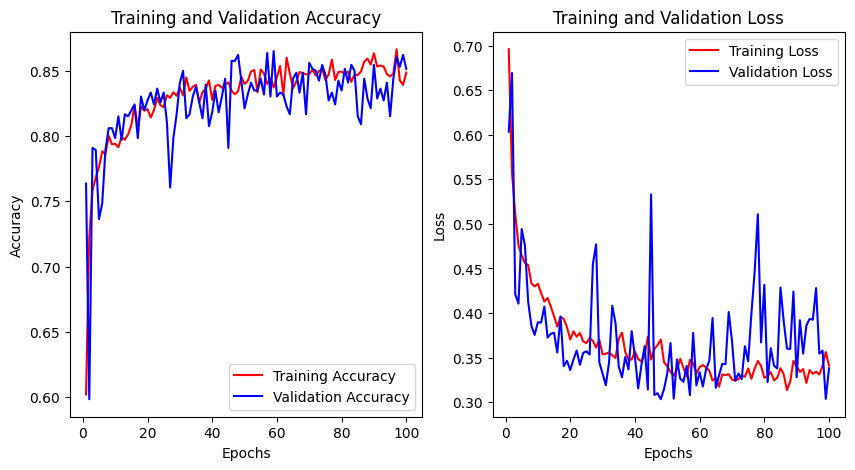

In [11]:
performance_dict_self_selected_best_model12 = history_self_selected_best_model23.history
accuracy_values = performance_dict_self_selected_best_model12["accuracy"]
val_accuracy_values = performance_dict_self_selected_best_model12["val_accuracy"]
loss_values = performance_dict_self_selected_best_model12["loss"]
val_loss_values = performance_dict_self_selected_best_model12["val_loss"]
epochs = range(1, len(accuracy_values) + 1)

fig, axs = plt.subplots(1, 2, figsize=(10, 5))

axs[0].plot(epochs, accuracy_values, "b", label="Training Accuracy", color='red')
axs[0].plot(epochs, val_accuracy_values, "b", label="Validation Accuracy")
axs[0].set_title("Training and Validation Accuracy")
axs[0].set_xlabel("Epochs")
axs[0].set_ylabel("Accuracy")
axs[0].legend()

axs[1].plot(epochs, loss_values, "b", label="Training Loss", color='red')
axs[1].plot(epochs, val_loss_values, "b", label="Validation Loss")
axs[1].set_title("Training and Validation Loss")
axs[1].set_xlabel("Epochs")
axs[1].set_ylabel("Loss")
axs[1].legend()

plt.show()

This model will be our final model as we no longer see overfitting as we are training on augmented images, and testing on non-augmented images. We also have implemented dropout on numerous layers. Our training accuracy high is 86.65% and validation accuracy high is 86.52%. 